In [1]:
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
import time
import math
import random
from pathlib import Path
import pandas as pd
import os
import h5py
import sys
sys.path.append('../')
from file_path import *

import torchvision
from torch.utils.data import Dataset, DataLoader, TensorDataset, ConcatDataset, random_split
from torchvision import transforms
from torch.utils import data
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_theme(style="ticks")

## Configuration 

In [354]:
class CFG:
    load_model = True
    best_loss = 0.000074043
    best_score = 0.001192254
    debug = False
    print_freq = 100
    num_workers = 4
    scheduler = "ReduceLROnPlateau" # CosineAnnealingLR / ReduceLROnPlateau / CosineAnnealingWarmRestarts
    model_name = "1dresnet-DR12Q-Redshift"
    epochs = 6
    T_max = 5
    lr = 0.2e-5
    min_lr = 1e-7
    batch_size = 64
    val_batch_size = 100
    weight_decay = 1e-5
    gradient_accumulation_steps = 1
    max_grad_norm = 1000 # Clipping Gradient Maximun
    factor = 0.2
    patience = 1
    eps = 1e-7
    seed = 1127802826
    n_fold = 1
    trn_fold = [0,1]  # [0, 1, 2, 3, 4]
    target_col = "target"
    train = True
    SAVEDIR = Path(runs_path)
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

## Utils

In [4]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    #score = roc_auc_score(y_true, y_pred)
    score = np.mean(np.abs((y_pred-y_true)/(1+y_true)))
    return score


def init_logger(log_file=CFG.SAVEDIR / '1dresnet-DR12Q-Redshift-train.log'):
    """Save Log to file"""
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    logger.propagate = False
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    """Random seed"""
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

## Load Data

In [319]:
f = h5py.File(feature_path+'dr16q-log-zvi-quasar.h5', 'r') 
f.keys()

g = h5py.File(feature_path+'dr16q-log-zvi-galaxy.h5', 'r') 

In [6]:
def norm(x_standard, x):
    """normalize redshift 0-1"""
    x_norm = (x - np.min(x_standard))/(np.max(x_standard)-np.min(x_standard))
    return x_norm

def inv_norm(x_standard, x_norm):
    x = x_norm*(np.max(x_standard)-np.min(x_standard)) + np.min(x_standard)
    return x

In [347]:
## read data
FLUX_NORM = f['flux_norm'][:]
Z_VI = f['z_vi'][:]
Z_QN= f['z_qn'][:]
Z_PIPE= f['z_pipe'][:]
Z_PCA= f['z_pca'][:]
Z_DR12Q= f['z_dr12q'][:]
PLATE = f['plate'][:]
MJD = f['mjd'][:]
FIBERIS = f['fiberid'][:]


# galaxy
FLUX_NORM_G = g['flux_norm'][:]
Z_VI_G = g['z_vi'][:]
Z_QN_G= g['z_qn'][:]
Z_PIPE_G= g['z_pipe'][:]
Z_PCA_G= g['z_pca'][:]
Z_DR12Q_G= g['z_dr12q'][:]
PLATE_G = g['plate'][:]
MJD_G = g['mjd'][:]
FIBERIS_G = g['fiberid'][:]

## filter only DR12
Z_DR12Q_12 = Z_DR12Q[Z_DR12Q>0]
Z_PCA_12 = Z_PCA[Z_DR12Q>0]
FLUX_NORM_12 = FLUX_NORM[Z_DR12Q>0]
Z_VI_12 = Z_VI[Z_DR12Q>0]
Z_QN_12 = Z_QN[Z_DR12Q>0]
PLATE_12 = PLATE[Z_DR12Q>0]
MJD_12 = MJD[Z_DR12Q>0]
FIBERIS_12 = FIBERIS[Z_DR12Q>0]

## filter only DR16, not in DR12
Z_DR12Q_16 = Z_DR12Q[Z_DR12Q==-1]
Z_PCA_16 = Z_PCA[Z_DR12Q==-1]
FLUX_NORM_16 = FLUX_NORM[Z_DR12Q==-1]
Z_VI_16 = Z_VI[Z_DR12Q==-1]
Z_QN_16 = Z_QN[Z_DR12Q==-1]
PLATE_16 = PLATE[Z_DR12Q==-1]
MJD_16 = MJD[Z_DR12Q==-1]
FIBERIS_16 = FIBERIS[Z_DR12Q==-1]

## filter only DR16, not in DR12 and Z_VI < 1.5
Z_DR12Q_16_lowZ = Z_DR12Q_16[Z_VI_16<1.5]
Z_PCA_16_lowZ  = Z_PCA_16[Z_VI_16<1.5]
FLUX_NORM_16_lowZ  = FLUX_NORM_16[Z_VI_16<1.5]
Z_VI_16_lowZ = Z_VI_16[Z_VI_16<1.5]
Z_QN_16_lowZ = Z_QN_16[Z_VI_16<1.5]
PLATE_16_lowZ = PLATE_16[Z_VI_16<1.5]
MJD_16_lowZ = MJD_16[Z_VI_16<1.5]
FIBERIS_16_lowZ = FIBERIS_16[Z_VI_16<1.5]

## filter only Z_QN=-1
Z_DR12Q_noZN = Z_DR12Q[Z_QN==-1]
Z_PCA_noZQN = Z_PCA[Z_QN==-1]
FLUX_NORM_noZQN = FLUX_NORM[Z_QN==-1]
Z_VI_noZQN = Z_VI[Z_QN==-1]
Z_QN_noZQN = Z_QN[Z_QN==-1]

PLATE_noZQN = PLATE[Z_QN==-1]
MJD_noZQN = MJD[Z_QN==-1]
FIBERIS_noZQN = FIBERIS[Z_QN==-1]

## Visual differs from PCA

In [208]:
e_PCA_VI = 3e5*(Z_PCA - Z_VI)/(1+Z_VI)
filter_PCA_VI = np.abs(e_PCA_VI)>6000

In [209]:
Z_DR12Q_PCA_VI = Z_DR12Q[filter_PCA_VI == True]
Z_PCA_PCA_VI = Z_PCA[filter_PCA_VI == True]
FLUX_NORM_PCA_VI = FLUX_NORM[filter_PCA_VI == True]
Z_VI_PCA_VI = Z_VI[filter_PCA_VI == True]
Z_QN_PCA_VI = Z_QN[filter_PCA_VI == True]
PLATE_PCA_VI = PLATE[filter_PCA_VI == True]
MJD_PCA_VI = MJD[filter_PCA_VI == True]
FIBERIS_PCA_VI = FIBERIS[filter_PCA_VI == True]

In [210]:
## split train and test data for original data

features = torch.Tensor(FLUX_NORM).view(-1,1,4618)
labels = torch.Tensor(norm(Z_VI_12,Z_VI)).view(-1,1)
names = torch.IntTensor(list(zip(PLATE,MJD,FIBERIS)))

features_train, features_test, labels_train, labels_test, names_train, names_test \
= train_test_split(features ,labels, names, test_size= 0.1,random_state = 42 )


features_12 = torch.Tensor(FLUX_NORM_12).view(-1,1,4618)
labels_12 = torch.Tensor(norm(Z_VI_12,Z_VI_12)).view(-1,1)
names_12 = torch.IntTensor(list(zip(PLATE_12,MJD_12,FIBERIS_12)))

features_train_12, features_test_12, labels_train_12, labels_test_12, names_train_12, names_test_12 \
= train_test_split(features_12 ,labels_12, names_12, test_size= 0.1,random_state = 42 )

features_16 = torch.Tensor(FLUX_NORM_16).view(-1,1,4618)
labels_16 = torch.Tensor(norm(Z_VI_12,Z_VI_16)).view(-1,1)
names_16 = torch.IntTensor(list(zip(PLATE_16,MJD_16,FIBERIS_16)))

features_16_lowZ = torch.Tensor(FLUX_NORM_16_lowZ).view(-1,1,4618)
labels_16_lowZ = torch.Tensor(norm(Z_VI_12,Z_VI_16_lowZ)).view(-1,1)
names_16_lowZ = torch.IntTensor(list(zip(PLATE_16_lowZ,MJD_16_lowZ,FIBERIS_16_lowZ)))

features_G = torch.Tensor(FLUX_NORM_G).view(-1,1,4618)
labels_G = torch.Tensor(norm(Z_VI_12,Z_VI_G)).view(-1,1)
names_G = torch.IntTensor(list(zip(PLATE_G,MJD_G,FIBERIS_G)))

features_train_16, features_test_16, labels_train_16, labels_test_16, names_train_16, names_test_16 \
= train_test_split(features_16 ,labels_16, names_16, test_size= 0.1,random_state = 42 )

features_noZQN = torch.Tensor(FLUX_NORM_noZQN).view(-1,1,4618)
labels_noZQN = torch.Tensor(norm(Z_VI_12,Z_VI_noZQN)).view(-1,1)
names_noZQN = torch.IntTensor(list(zip(PLATE_noZQN,MJD_noZQN,FIBERIS_noZQN)))

In [211]:
features_PCA_VI = torch.Tensor(FLUX_NORM_PCA_VI).view(-1,1,4618)
labels_PCA_VI_VI = torch.Tensor(norm(Z_VI_12,Z_VI_PCA_VI)).view(-1,1)
labels_PCA_VI_PCA = torch.Tensor(norm(Z_VI_12,Z_PCA_PCA_VI)).view(-1,1)
names_PCA_VI = torch.IntTensor(list(zip(PLATE_PCA_VI,MJD_PCA_VI,FIBERIS_PCA_VI)))

In [ ]:
features_PCA_VI = torch.Tensor(FLUX_NORM_PCA_VI).view(-1,1,4618)
labels_PCA_VI_VI = torch.Tensor(norm(Z_VI_12,Z_VI_PCA_VI)).view(-1,1)
names_PCA_VI = torch.IntTensor(list(zip(PLATE_PCA_VI,MJD_PCA_VI,FIBERIS_PCA_VI)))

In [349]:
len(labels),len(labels_12),len(labels_16),len(features_16_lowZ),len(labels_noZQN)

(396831, 267106, 129725, 44952, 5190)

In [10]:
### iterators
#
#train_iter = DataLoader(TensorDataset(features_train, labels_train, names_train), 
#                        batch_size=CFG.batch_size, 
#                        shuffle=True, 
#                        num_workers=CFG.num_workers)
#
#test_iter = DataLoader(TensorDataset(features_test, labels_test, names_test), 
#                        batch_size=CFG.batch_size, 
#                        shuffle=True, 
#                        num_workers=CFG.num_workers)

## Helper functions

In [11]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def max_memory_allocated(device):
    MB = 1024.0 * 1024.0
    mem = torch.cuda.max_memory_allocated(device) / MB
    return f"{mem:.0f} MB"

def sdss_id(index):
    return '-'.join(map(str, index))

def get_result(result_df):
    preds = result_df['preds'].values
    labels = result_df[CFG.target_col].values
    score = get_score(labels, preds)
    LOGGER.info(f'Score: {score:<.9f}')

## Loss

In [12]:
def z_loss(pred, label):
    #return torch.mean(torch.abs((pred-label)/(1+label)))
    return nn.MSELoss()

## Model

In [13]:
class Residual(nn.Module):
    def __init__(self, in_channels, out_channels, use_1x1conv=False, stride=1):
        super(Residual, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=500, padding=250, stride=stride)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=200, padding=100, stride=stride)
        self.conv3 = nn.Conv1d(out_channels, out_channels, kernel_size=15, padding=6, stride=1)
        if use_1x1conv:
            self.conv4 = nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride)
        else:
            self.conv4 = None
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.bn3 = nn.BatchNorm1d(out_channels)
        #self.fc = nn.Linear(in_features, out_features, bias=True)
        
    def forward(self, x):
        y1 = F.relu(self.bn1(self.conv1(x)))
        y2 = F.relu(self.bn2(self.conv2(y1)))
        y3 = self.bn3(self.conv3(y2))
        if self.conv4:
            x = self.conv4(x)
        return F.relu(y3+x)
    
    
def resnet_block(in_channels, out_channels, num_residuals, stride=1):
    blk = []
    for i in range(num_residuals):
        if i==0:
            blk.append(Residual(in_channels, out_channels, use_1x1conv=True, stride=stride))
        else:
            blk.append(Residual(out_channels, out_channels))
    return nn.Sequential(*blk)

def resnet():
    model = nn.Sequential()
    model.add_module('resnet_block_1', resnet_block(in_channels=1, out_channels=32, num_residuals=5, stride=1))
    model.add_module('resnet_block_2', resnet_block(in_channels=32, out_channels=64, num_residuals=1, stride=1))
    model.add_module('resnet_block_3', resnet_block(in_channels=64, out_channels=32, num_residuals=1, stride=1))
    model.add_module('resnet_block_4', resnet_block(in_channels=32, out_channels=1, num_residuals=1, stride=1))
    model.add_module('flatten', nn.Flatten())
    model.add_module('fc1', nn.Sequential(nn.Linear(in_features=4618, out_features=796, bias=True), nn.ReLU()))
    model.add_module('fc2', nn.Sequential(nn.Linear(in_features=796, out_features=199, bias=True), nn.ReLU()))
    model.add_module('fc3', nn.Linear(in_features=199, out_features=1, bias=True))
    return model

In [14]:
model = resnet()

In [16]:
#model.load_state_dict(torch.load(runs_path+'CNN-cv-main-DR12Q-63000-ResNet-24-for-all-10epoches.pt'))

In [17]:
# test
x = torch.rand(1,1,4618)
model(x)

tensor([[-0.0622]], grad_fn=<AddmmBackward>)

## Trainer

In [15]:
def train_fn(files, model, criterion, optimizer, epoch, scheduler, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()

    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    
    train_loader = DataLoader(files, 
                              batch_size=CFG.batch_size, 
                              shuffle=True, 
                              num_workers=CFG.num_workers)

    for step, d in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        x = d[0].to(device)
        labels = d[1].to(device)

        batch_size = labels.size(0)
        y_preds = model(x)
        loss = criterion(y_preds, labels)
        # record loss
        losses.update(loss, batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0:
            output = 'Epoch: [{0}/{1}][{2}/{3}] '\
                     'Loss: {loss.val:.9f}({loss.avg:.9f}) '\
                     'Grad: {grad_norm:.9f}  '\
                     'LR: {lr:.9f}  '\
                     'Elapsed: {remain:s} '\
                     'Max mem: {mem:s}'.format(
                      epoch+1, CFG.epochs, step, len(train_loader),
                      loss=losses,
                      grad_norm=grad_norm,
                      #lr=scheduler.get_last_lr()[0],
                      lr=optimizer.param_groups[0]['lr'],
                      remain=timeSince(start, float(step + 1) / len(train_loader)),
                      mem=max_memory_allocated(CFG.device))
            #print(output)
            LOGGER.info(output)
    return losses.avg


def valid_fn(files, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    filenames = []
    targets = []
    preds = []
    start = end = time.time()
    
    valid_loader = DataLoader(files, 
                              batch_size=CFG.batch_size, 
                              shuffle=True, 
                              num_workers=CFG.num_workers)
    
    for step, d in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        
        targets.extend(d[1])
        filenames.extend(d[2].numpy())
        x = d[0].to(device)
        labels = d[1].to(device)

        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(x)
            
        loss = criterion(y_preds.view(-1), labels.view(-1))
        losses.update(loss.item(), batch_size)

        preds.append(y_preds.to('cpu').numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0: 
            output = 'EVAL: [{0}/{1}] '\
                     'Data {data_time.val:.3f} ({data_time.avg:.3f}) '\
                     'Elapsed {remain:s} '\
                     'Loss: {loss.val:.9f}({loss.avg:.9f}) '.format(
                     step, len(valid_loader), batch_time=batch_time,
                     data_time=data_time, loss=losses,
                     remain=timeSince(start, float(step+1)/len(valid_loader)),
                     )
            #print(output)
            LOGGER.info(output)
    predictions = np.concatenate(preds).reshape(-1)
    return losses.avg, predictions, np.array(targets), np.array(filenames).reshape(-1,3)
#    return losses.avg, predictions, np.array(targets)

## Train loop

In [16]:
# ====================================================
# Train loop
# ====================================================
def train_loop(train_files, val_files, fold=99, load_model = False):
    
    if (CFG.n_fold==1):
        LOGGER.info(f"========== training ==========")
    else:
        LOGGER.info(f"========== fold: {fold} training ==========")
    
    # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                             mode='min', 
                                                             factor=CFG.factor, 
                                                             patience=CFG.patience, 
                                                             verbose=True, 
                                                             eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 
                                                             T_max=CFG.T_max, 
                                                             eta_min=CFG.min_lr, 
                                                             last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 
                                                                       T_0=CFG.T_0, 
                                                                       T_mult=1, 
                                                                       eta_min=CFG.min_lr, 
                                                                       last_epoch=-1)
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
#    if first_run:
    model.to(CFG.device)
    if load_model:
        model.load_state_dict(torch.load(CFG.SAVEDIR / f"{CFG.model_name}_fold{fold}_best_score.pth")["model"])
        LOGGER.info(f"========== Model loaded: {CFG.model_name}_fold{fold}_best_score.pth ==========")

    optimizer = optim.Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
    scheduler = get_scheduler(optimizer)
    criterion = nn.MSELoss()
    
    if load_model:
        best_score = CFG.best_score
        best_loss = CFG.best_loss
    else:
        best_score = np.inf
        best_loss = np.inf


    # ====================================================
    # loop
    # ====================================================
    
    for epoch in range(CFG.epochs):
        print("\n\n")
        start_time = time.time()
        
        # train
        avg_loss = train_fn(train_files, model, criterion, optimizer, epoch, scheduler, CFG.device)

        # eval
        avg_val_loss, preds, targets, files = valid_fn(val_files, model, criterion, CFG.device)
        files = np.array([sdss_id(x) for x in np.array(files).reshape(-1,3)])
        valid_result_df = pd.DataFrame({"target": targets, "preds": preds, "id": files})
        
        # scheduler the learning rate
        if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, optim.lr_scheduler.CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, optim.lr_scheduler.CosineAnnealingWarmRestarts):
            scheduler.step()

        # scoring
        score = get_score(targets, preds)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.9f}  avg_val_loss: {avg_val_loss:.9f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.9f}')
            
        # save models of best score and best loss
        if score < best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.9f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        CFG.SAVEDIR / f'{CFG.model_name}_fold{fold}_best_score.pth')
            
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            LOGGER.info(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.9f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        CFG.SAVEDIR / f'{CFG.model_name}_fold{fold}_best_loss.pth')
    
    # prediction from the model of best loss
    valid_result_df["preds"] = torch.load(CFG.SAVEDIR / f"{CFG.model_name}_fold{fold}_best_loss.pth",
                                          map_location="cpu")["preds"]

    return valid_result_df

## Training 

In [20]:
train_files = TensorDataset(features_train[:], labels_train[:], names_train[:])
test_files = TensorDataset(features_test[:], labels_test[:], names_test[:])
all_files = TensorDataset(features[:], labels[:], names[:])

In [17]:
train_files = TensorDataset(features_train_12[:], labels_train_12[:], names_train_12[:])
test_files = TensorDataset(features_test_12[:], labels_test_12[:], names_test_12[:])
all_files = TensorDataset(features_12[:], labels_12[:], names_12[:])

In [352]:
train_files = TensorDataset(features_16_lowZ[:], labels_16_lowZ[:], names_16_lowZ[:])
test_files = TensorDataset(features_test_12[:], labels_test_12[:], names_test_12[:])
all_files = TensorDataset(features_16_lowZ[:], labels_16_lowZ[:], names_16_lowZ[:])

In [ ]:
def get_result(result_df):
    preds = result_df['preds'].values
    labels = result_df[CFG.target_col].values
    score = get_score(labels, preds)
    LOGGER.info(f'Score: {score:<.9f}')

if CFG.train:
    # train 
    LOGGER.info(f"********** Start at {time.asctime( time.localtime(time.time()) )}  **********")
    
    # training one time by setting CFG.n_fold=1
    if (CFG.n_fold==1):
        oof_df = train_loop(train_files, test_files, load_model=CFG.load_model)
        LOGGER.info(f"========== result ==========")
        get_result(oof_df)
    
    # K-Fold traning if CFG.n_fold>1
    if (CFG.n_fold>1):
        oof_df = pd.DataFrame()
        kf = KFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
        folds = list(kf.split(all_files))
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                trn_idx, val_idx = folds[fold]
                train_files = TensorDataset(*all_files[trn_idx])
                valid_files = TensorDataset(*all_files[val_idx])
                _oof_df = train_loop(train_files, valid_files, fold, load_model=CFG.load_model)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        # CV result
        LOGGER.info(f"========== CV result ==========")
        get_result(oof_df)
        
    # save result
    oof_df.to_csv(CFG.SAVEDIR / f"{CFG.model_name}.csv", index=False)
    LOGGER.info(f"********** End at {time.asctime( time.localtime(time.time()) )} **********")

********** Start at Tue Nov 30 05:50:57 2021  **********
========== training ==========
========== Model loaded: 1dresnet-DR12Q-Redshift_fold99_best_loss.pth ==========


Epoch: [1/6][0/703] Loss: 0.008236944(0.008236944) Grad: 0.334314406  LR: 0.000002000  Elapsed: 0m 2s (remain 25m 1s) Max mem: 2830 MB
Epoch: [1/6][100/703] Loss: 0.001492909(0.002738744) Grad: 0.075938240  LR: 0.000002000  Elapsed: 2m 13s (remain 13m 15s) Max mem: 2909 MB


## Debug Code

In [34]:
fold = 99

In [35]:
model.load_state_dict(torch.load(CFG.SAVEDIR / f"{CFG.model_name}_fold99_best_score.pth")["model"])

<All keys matched successfully>

In [36]:
def get_scheduler(optimizer):
    if CFG.scheduler=='ReduceLROnPlateau':
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                         mode='min', 
                                                         factor=CFG.factor, 
                                                         patience=CFG.patience, 
                                                         verbose=True, 
                                                         eps=CFG.eps)
    elif CFG.scheduler=='CosineAnnealingLR':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 
                                                         T_max=CFG.T_max, 
                                                         eta_min=CFG.min_lr, 
                                                         last_epoch=-1)
    elif CFG.scheduler=='CosineAnnealingWarmRestarts':
        scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 
                                                                   T_0=CFG.T_0, 
                                                                   T_mult=1, 
                                                                   eta_min=CFG.min_lr, 
                                                                   last_epoch=-1)
    return scheduler

In [37]:
#model = resnet()
#model.to(CFG.device)

#optimizer = optim.Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
#scheduler = get_scheduler(optimizer)

criterion = nn.MSELoss()

#best_score = 0.
#best_loss = np.inf
#model.to(CFG.device)

Sequential(
  (resnet_block_1): Sequential(
    (0): Residual(
      (conv1): Conv1d(1, 32, kernel_size=(500,), stride=(1,), padding=(250,))
      (conv2): Conv1d(32, 32, kernel_size=(200,), stride=(1,), padding=(100,))
      (conv3): Conv1d(32, 32, kernel_size=(15,), stride=(1,), padding=(6,))
      (conv4): Conv1d(1, 32, kernel_size=(1,), stride=(1,))
      (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Residual(
      (conv1): Conv1d(32, 32, kernel_size=(500,), stride=(1,), padding=(250,))
      (conv2): Conv1d(32, 32, kernel_size=(200,), stride=(1,), padding=(100,))
      (conv3): Conv1d(32, 32, kernel_size=(15,), stride=(1,), padding=(6,))
      (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): 

## Prediction

### All Test Samples

In [189]:
# prediction
a, b, c, d = valid_fn(TensorDataset(features_test, labels_test, names_test), model, criterion, CFG.device)

EVAL: [0/621] Data 1.113 (1.113) Elapsed 0m 1s (remain 16m 15s) Loss: 0.000003856(0.000003856) 
EVAL: [0/621] Data 1.113 (1.113) Elapsed 0m 1s (remain 16m 15s) Loss: 0.000003856(0.000003856) 
EVAL: [100/621] Data 0.002 (0.013) Elapsed 0m 46s (remain 3m 59s) Loss: 0.000131355(0.000278104) 
EVAL: [100/621] Data 0.002 (0.013) Elapsed 0m 46s (remain 3m 59s) Loss: 0.000131355(0.000278104) 
EVAL: [200/621] Data 0.002 (0.007) Elapsed 1m 31s (remain 3m 11s) Loss: 0.000518562(0.000236595) 
EVAL: [200/621] Data 0.002 (0.007) Elapsed 1m 31s (remain 3m 11s) Loss: 0.000518562(0.000236595) 
EVAL: [300/621] Data 0.002 (0.005) Elapsed 2m 16s (remain 2m 25s) Loss: 0.000023374(0.000322171) 
EVAL: [300/621] Data 0.002 (0.005) Elapsed 2m 16s (remain 2m 25s) Loss: 0.000023374(0.000322171) 
EVAL: [400/621] Data 0.002 (0.005) Elapsed 3m 2s (remain 1m 39s) Loss: 0.000008227(0.000307275) 
EVAL: [400/621] Data 0.002 (0.005) Elapsed 3m 2s (remain 1m 39s) Loss: 0.000008227(0.000307275) 
EVAL: [500/621] Data 0.002

In [97]:
# velocity dispersoin
e = 300000*((inv_norm(Z_VI_12, b) - inv_norm(Z_VI_12, c))/(1+inv_norm(Z_VI_12, c)))
print(abs(e).mean(),e.mean(),np.median(abs(e)))

2010.4027599029014 314.8665608223601 457.0461984258145


In [99]:
# percentage of spectra with velocity smaller than a value
print(len(e[np.abs(e)<6000])/len(e),len(e[np.abs(e)<12000])/len(e),len(e[np.abs(e)<30000])/len(e))

accs_e = []
for t in np.arange(0,3e5,100):
    acc = len(e[np.abs(e)<t])/len(e)
    accs_e.append(acc*100)

0.9687783489567584 0.9800927325874408 0.98876121358734


In [115]:
## QuasarNet

X_train1, X_test1, Y_train1, Y_test1 = train_test_split(FLUX_NORM ,Z_QN, test_size= 0.1,random_state = 42 )
Y_ZV = inv_norm(Z_VI_12, labels_test.numpy().reshape(-1))
e_Q = 300000*((Y_test1 - Y_ZV)/(1+Y_ZV))
print(abs(e_Q).mean(),e_Q.mean(),np.median(abs(e_Q)))

5598.41415464011 -3799.165386291346 392.2124218661338


In [133]:
#X_train1, X_test1, Y_train1, Y_test1 = train_test_split(FLUX_NORM ,Z_QN, test_size= 0.1,random_state = 42 )
#Y_ZV = inv_norm(Z_VI_12, labels_test.numpy().reshape(-1))
e_Q = 300000*((Z_QN - Z_VI)/(1+Z_VI))
print(abs(e_Q).mean(),e_Q.mean(),np.median(abs(e_Q)))

5529.326381453036 -3688.078912288354 391.20566798374057


In [134]:
print(len(e_Q[np.abs(e_Q)<6000])/len(e_Q),len(e_Q[np.abs(e_Q)<12000])/len(e_Q),len(e_Q[np.abs(e_Q)<30000])/len(e_Q))
accs_e_Q = []
for t in np.arange(0,3e5,100):
    acc = len(e_Q[np.abs(e_Q)<t])/len(e_Q)
    accs_e_Q.append(acc*100)

0.9776983148997936 0.9785399830154399 0.9790439758990603


In [142]:
e_Q[e_Q<-2.999e5]

array([-300000., -300000., -300000., ..., -300000., -300000., -300000.])

## DR12 Sample, filtered from DR16Q by Z_DR12Q>0

In [ ]:
a_12, b_12, c_12, d_12 = valid_fn(TensorDataset(features_test_12, labels_test_12, names_test_12), model, criterion, CFG.device)

In [100]:
e_12 = 300000*((inv_norm(Z_VI_12, b_12) - inv_norm(Z_VI_12, c_12))/(1+inv_norm(Z_VI_12, c_12)))
print(abs(e_12).mean(),e_12.mean(),np.median(abs(e_12)))

1107.1355501010512 112.10771883591876 424.10603491589427


In [101]:
print(len(e_12[np.abs(e_12)<6000])/len(e_12),len(e_12[np.abs(e_12)<12000])/len(e_12),len(e_12[np.abs(e_12)<30000])/len(e_12))

0.986185466661675 0.9919508816592415 0.9955449065927895


## DR16 Sample, filtered from DR16Q by Z_DR12Q==-1

In [80]:
a_16, b_16, c_16, d_16 = valid_fn(TensorDataset(features_16, labels_16, names_16), model, criterion, CFG.device)

EVAL: [0/2027] Data 1.031 (1.031) Elapsed 0m 1s (remain 50m 20s) Loss: 0.000178367(0.000178367) 
EVAL: [100/2027] Data 0.002 (0.012) Elapsed 0m 46s (remain 14m 42s) Loss: 0.000346154(0.001007485) 
EVAL: [200/2027] Data 0.002 (0.007) Elapsed 1m 31s (remain 13m 48s) Loss: 0.000218825(0.001036054) 
EVAL: [300/2027] Data 0.002 (0.005) Elapsed 2m 16s (remain 13m 0s) Loss: 0.000076953(0.000910771) 
EVAL: [400/2027] Data 0.002 (0.004) Elapsed 3m 1s (remain 12m 14s) Loss: 0.000002607(0.000855052) 
EVAL: [500/2027] Data 0.002 (0.004) Elapsed 3m 46s (remain 11m 28s) Loss: 0.000594664(0.000839276) 
EVAL: [600/2027] Data 0.002 (0.004) Elapsed 4m 31s (remain 10m 43s) Loss: 0.000825860(0.000833565) 
EVAL: [700/2027] Data 0.002 (0.003) Elapsed 5m 16s (remain 9m 58s) Loss: 0.000019027(0.000833164) 
EVAL: [800/2027] Data 0.002 (0.003) Elapsed 6m 1s (remain 9m 12s) Loss: 0.000116411(0.000860127) 
EVAL: [900/2027] Data 0.002 (0.003) Elapsed 6m 46s (remain 8m 27s) Loss: 0.000054228(0.000877398) 
EVAL: [10

In [102]:
e_16 = 300000*((inv_norm(Z_VI_12, b_16) - inv_norm(Z_VI_12, c_16))/(1+inv_norm(Z_VI_12, c_16)))
print(abs(e_16).mean(),e_16.mean(),np.median(abs(e_16)))

4426.588757141976 848.2984176233114 551.0151037015021


In [120]:
print(len(e_16[np.abs(e_16)<6000])/len(e_16),len(e_16[np.abs(e_16)<12000])/len(e_16),len(e_16[np.abs(e_16)<30000])/len(e_16))

accs_16 = []
for t in np.arange(0,3e5,100):
    acc = len(e_16[np.abs(e_16)<t])/len(e_16)
    accs_16.append(acc*100)

0.929304297552515 0.9486991713239545 0.9680709192522644


In [119]:
# QuasarNet
e_Q_16 = 300000*((Z_QN_16 - Z_VI_16)/(1+ Z_VI_16))
print(abs(e_Q_16).mean(),e_Q_16.mean(),np.median(abs(e_Q_16)))

14843.558467584244 -10663.129481538877 452.776369638741


In [122]:
print(len(e_Q_16[np.abs(e_Q_16)<6000])/len(e_Q_16),len(e_Q_16[np.abs(e_Q_16)<12000])/len(e_Q_16),len(e_Q_16[np.abs(e_Q_16)<30000])/len(e_Q_16))
accs_Q_16 = []

for t in np.arange(0,3e5,100):
    acc = len(e_Q_16[np.abs(e_Q_16)<t])/len(e_Q_16)
    accs_Q_16.append(acc*100)

0.9368741568703025 0.9390479861244941 0.9404663711697823


## Only predicted by FNet, by filtering Z_QN=-1

In [106]:
a_noZQN, b_noZQN, c_noZQN, d_noZQN = valid_fn(TensorDataset(features_noZQN, labels_noZQN, names_noZQN), model, criterion, CFG.device)

EVAL: [0/163] Data 0.954 (0.954) Elapsed 0m 1s (remain 3m 14s) Loss: 0.000032257(0.000032257) 
EVAL: [100/163] Data 0.002 (0.011) Elapsed 0m 24s (remain 0m 14s) Loss: 0.001128508(0.001479353) 


In [107]:
e_noZQN = 300000*((inv_norm(Z_VI_12, b_noZQN) - inv_norm(Z_VI_12, c_noZQN))/(1+inv_norm(Z_VI_12, c_noZQN)))
print(abs(e_noZQN).mean(),e_noZQN.mean(),np.median(abs(e_noZQN)))

7669.5917595743185 3165.6130711922624 915.3494029305875


In [109]:
print(len(e_noZQN[np.abs(e_noZQN)<6000])/len(e_noZQN),len(e_noZQN[np.abs(e_noZQN)<12000])/len(e_noZQN),len(e_noZQN[np.abs(e_noZQN)<30000])/len(e_noZQN))
accs_noZQN = []
for t in np.arange(0,3e5,100):
    acc = len(e_noZQN[np.abs(e_noZQN)<t])/len(e_noZQN)
    accs_noZQN.append(acc*100)

0.873795761078998 0.9175337186897881 0.9514450867052023


## PCA and Vi have difference > 6000 km/s

In [315]:
e_PCA_VI_ALL = 3e5*(Z_PCA - Z_VI)/(1+Z_VI)

In [318]:
print(len(e_PCA_VI_ALL[np.abs(e_PCA_VI_ALL)<6000])/len(e_PCA_VI_ALL),len(e_PCA_VI_ALL[np.abs(e_PCA_VI_ALL)<12000])/len(e_PCA_VI_ALL),len(e_PCA_VI_ALL[np.abs(e_PCA_VI_ALL)<30000])/len(e_PCA_VI_ALL))

0.9955169833001958 0.9974976753328243 0.997661473020001


In [314]:
Z_VI

array([3.012  , 2.754  , 0.397  , ..., 3.74474, 2.40566, 2.3095 ],
      dtype=float32)

In [213]:
a_PCA_VI_VI, b_PCA_VI_VI, c_PCA_VI_VI, d_PCA_VI_VI = valid_fn(TensorDataset(features_PCA_VI, labels_PCA_VI_VI, names_PCA_VI), model, criterion, CFG.device)

EVAL: [0/56] Data 1.097 (1.097) Elapsed 0m 1s (remain 1m 13s) Loss: 0.027269239(0.027269239) 


In [214]:
a_PCA_VI_PCA, b_PCA_VI_PCA, c_PCA_VI_PCA, d_PCA_VI_PCA = valid_fn(TensorDataset(features_PCA_VI, labels_PCA_VI_PCA, names_PCA_VI), model, criterion, CFG.device)

EVAL: [0/56] Data 1.101 (1.101) Elapsed 0m 1s (remain 1m 13s) Loss: 0.071903564(0.071903564) 


In [ ]:
a_PCA_VI_QN, b_PCA_VI_QN, c_PCA_VI_QN, d_PCA_VI_QN = valid_fn(TensorDataset(features_PCA_VI, labels_PCA_VI_QN, names_PCA_VI), model, criterion, CFG.device)

In [228]:
e_PCA_VI_VI = 300000*((inv_norm(Z_VI_12, b_PCA_VI_VI) - inv_norm(Z_VI_12, c_PCA_VI_VI))/(1+inv_norm(Z_VI_12, c_PCA_VI_VI)))
print(abs(e_PCA_VI_VI).mean(),e_PCA_VI_VI.mean(),np.median(abs(e_PCA_VI_VI)))

71545.00553283413 18487.28120254228 50829.09017801285


In [229]:
e_PCA_VI_PCA = 300000*((inv_norm(Z_VI_12, b_PCA_VI_PCA) - inv_norm(Z_VI_12, c_PCA_VI_PCA))/(1+inv_norm(Z_VI_12, c_PCA_VI_PCA)))
print(abs(e_PCA_VI_PCA).mean(),e_PCA_VI_PCA.mean(),np.median(abs(e_PCA_VI_PCA)))

113940.01038518768 56098.914284976956 60357.20407962799


In [218]:
print(len(e_PCA_VI_VI[np.abs(e_PCA_VI_VI)<6000])/len(e_PCA_VI_VI),len(e_PCA_VI_VI[np.abs(e_PCA_VI_VI)<12000])/len(e_PCA_VI_VI),len(e_PCA_VI_VI[np.abs(e_PCA_VI_VI)<30000])/len(e_PCA_VI_VI))
accs_PCA_VI_VI = []
for t in np.arange(0,3e5,100):
    acc = len(e_PCA_VI_VI[np.abs(e_PCA_VI_VI)<t])/len(e_PCA_VI_VI)
    accs_PCA_VI_VI.append(acc*100)

0.21135469364811693 0.26812816188870153 0.39572793704328274


In [219]:
print(len(e_PCA_VI_PCA[np.abs(e_PCA_VI_PCA)<6000])/len(e_PCA_VI_PCA),len(e_PCA_VI_PCA[np.abs(e_PCA_VI_PCA)<12000])/len(e_PCA_VI_PCA),len(e_PCA_VI_PCA[np.abs(e_PCA_VI_PCA)<30000])/len(e_PCA_VI_PCA))
accs_PCA_VI_PCA = []
for t in np.arange(0,3e5,100):
    acc = len(e_PCA_VI_PCA[np.abs(e_PCA_VI_PCA)<t])/len(e_PCA_VI_PCA)
    accs_PCA_VI_PCA.append(acc*100)

0.15345699831365936 0.2596964586846543 0.36031478358628444


## Prediction redshfit for galaxy

In [112]:
a_g, b_g, c_g, d_g = valid_fn(TensorDataset(features_G, labels_G, names_G), model, criterion, CFG.device)

EVAL: [0/959] Data 0.957 (0.957) Elapsed 0m 1s (remain 19m 9s) Loss: 0.018771939(0.018771939) 
EVAL: [100/959] Data 0.002 (0.011) Elapsed 0m 24s (remain 3m 26s) Loss: 0.011998477(0.020502082) 
EVAL: [200/959] Data 0.002 (0.006) Elapsed 0m 47s (remain 2m 59s) Loss: 0.013583285(0.020964571) 
EVAL: [300/959] Data 0.002 (0.005) Elapsed 1m 10s (remain 2m 34s) Loss: 0.019644197(0.020795435) 
EVAL: [400/959] Data 0.002 (0.004) Elapsed 1m 33s (remain 2m 10s) Loss: 0.022504315(0.021045777) 
EVAL: [500/959] Data 0.002 (0.004) Elapsed 1m 57s (remain 1m 47s) Loss: 0.032054473(0.021288866) 
EVAL: [600/959] Data 0.002 (0.003) Elapsed 2m 20s (remain 1m 23s) Loss: 0.014859136(0.021329308) 
EVAL: [700/959] Data 0.002 (0.003) Elapsed 2m 43s (remain 1m 0s) Loss: 0.016433056(0.021230869) 
EVAL: [800/959] Data 0.002 (0.003) Elapsed 3m 6s (remain 0m 36s) Loss: 0.028121388(0.021215109) 
EVAL: [900/959] Data 0.002 (0.003) Elapsed 3m 30s (remain 0m 13s) Loss: 0.028036045(0.021323367) 


In [113]:
e_g = 300000*((inv_norm(Z_VI_12, b_g) - inv_norm(Z_VI_12, c_g))/(1+inv_norm(Z_VI_12, c_g)))
print(abs(e_g).mean(),e_g.mean(),np.median(abs(e_g)))

164475.99261662838 160325.13379826472 113412.31316328049


In [114]:
print(len(e_g[np.abs(e_g)<6000])/len(e_g),len(e_g[np.abs(e_g)<12000])/len(e_g),len(e_g[np.abs(e_g)<30000])/len(e_g))

0.059740429139763906 0.09769777603860953 0.17892780277832127


In [278]:
QNet_file = feature_path+'DR12Q-63000.h5'
QNet = h5py.File(QNet_file, 'r') 
Q_Z_VI = QNet['Z_DR12Q_VI'][:]
Q_Z_QN= QNet['Z_QN'][:]
e_Q = 300000*(Q_Z_VI - Q_Z_QN)/(1+Q_Z_QN)
#e_Q_same = e_Q[:int(len(e)/1.013)]
e_Q_same = e_Q[:int(len(e))]

In [279]:
len(e_Q[np.abs(e_Q)<6000])/len(e_Q),len(e_Q[np.abs(e_Q)<12000])/len(e_Q),len(e_Q[np.abs(e_Q)<30000])/len(e_Q)

(0.9979873217115689, 0.9981616481774961, 0.998256735340729)

In [78]:
QNet_file = feature_path+'DR12Q-63000.h5'
QNet = h5py.File(QNet_file, 'r') 
Q_Z_VI = QNet['Z_DR12Q_VI'][:]
Q_Z_QN= QNet['Z_QN'][:]
e_Q = 300000*(Q_Z_VI - Q_Z_QN)/(1+Q_Z_QN)
e_Q_same = e_Q[:int(len(e_12))]
#e_Q_same = e_Q[:int(len(e_12))]

/home/wangyu/miniconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


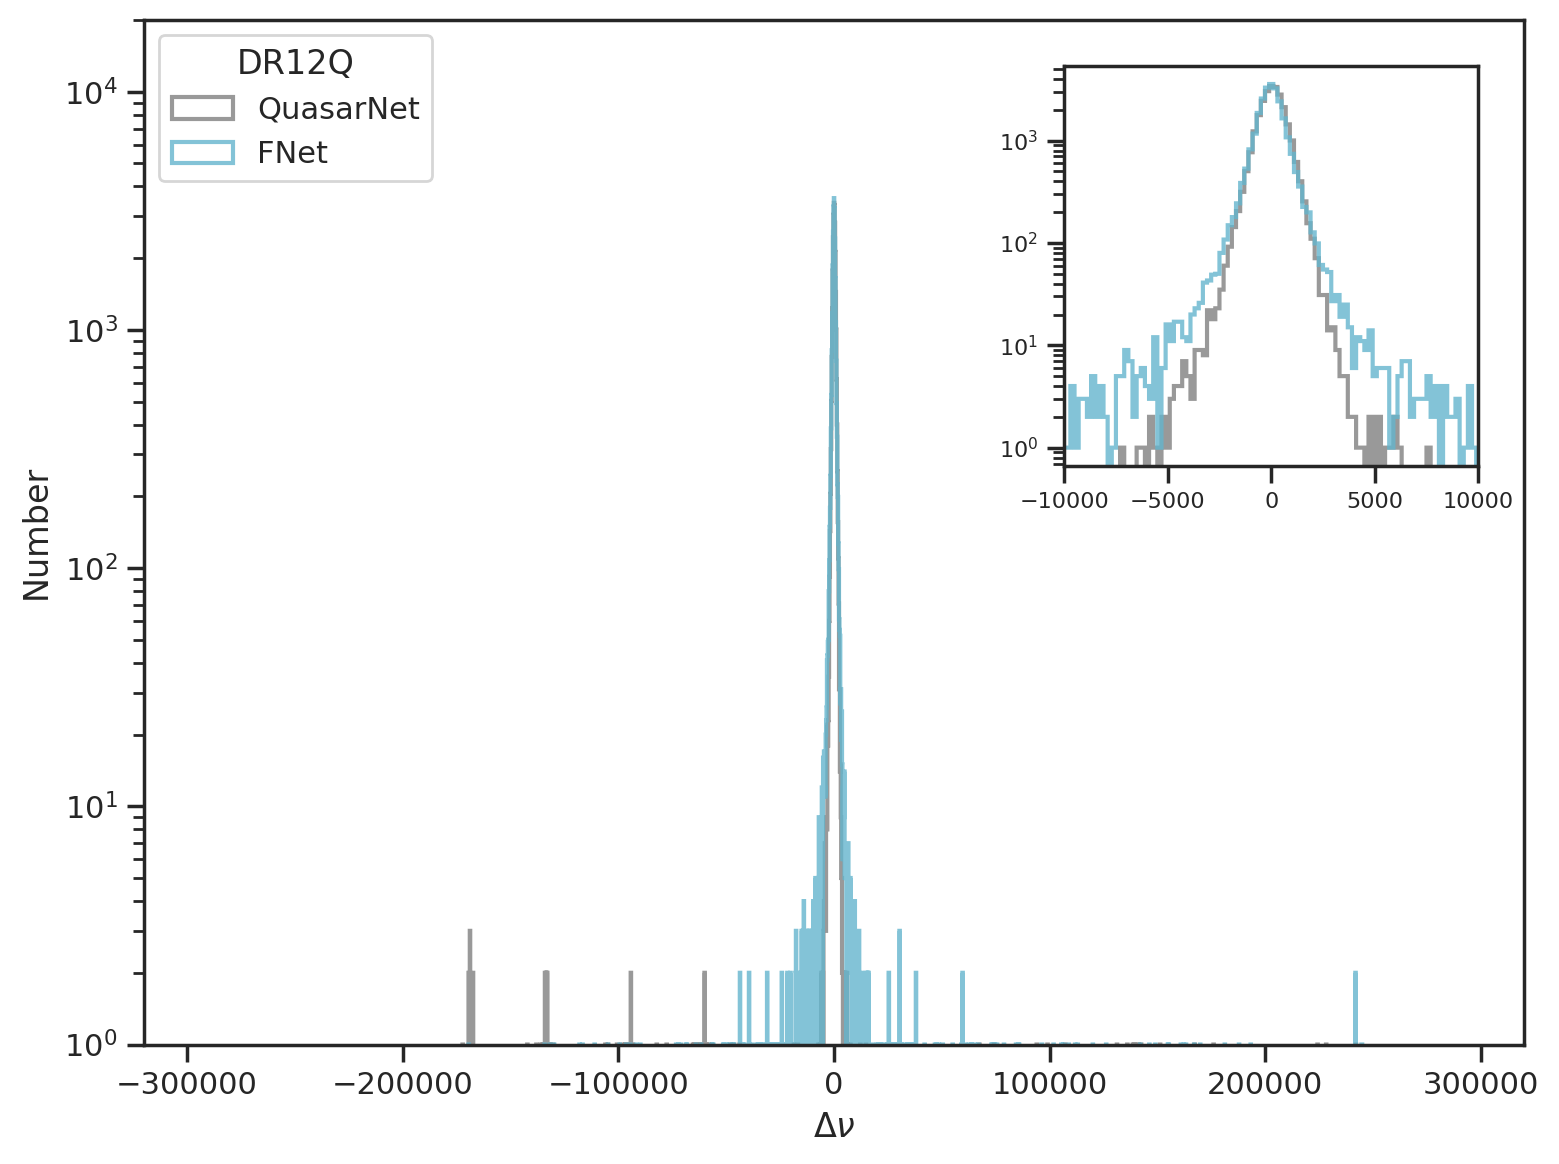

In [80]:
fig, ax = plt.subplots()
plt.hist(e_Q_same, bins=np.linspace(-5e5,5e5,5000),histtype='step',alpha=0.8,edgecolor='grey',linewidth=1.5,label='QuasarNet')
plt.hist(e_12, bins=np.linspace(-5e5,5e5,5000),histtype='step',alpha=0.8,edgecolor='C9',linewidth=1.5,label='FNet')

#plt.hist(e_noZQN, bins=np.linspace(-5e5,5e5,5000),histtype='step',alpha=0.8,edgecolor='C3',linewidth=1.5,label='FNet')



plt.legend(title='DR12Q',loc=2)
plt.xlim(-320000,320000)
plt.ylim(1,2e4)
#plt.xlim(-6000,6000)

#plt.ylim(1,1000)
plt.xlabel(r'$\Delta \nu$',fontsize=12)
plt.ylabel('Number',fontsize=12)
plt.yscale('log')

from mpl_toolkits.axes_grid.inset_locator import inset_axes
ax_in = inset_axes(ax,
                    width="30%", # width = 30% of parent_bbox
                    height=2., # height : 1 inch
                    borderpad=1.5,
                    loc=1)

ax_in.hist(e_Q_same, bins=np.linspace(-5e5,5e5,5000),histtype='step',alpha=0.8,edgecolor='grey',linewidth=1.5,label='QuasarNet')
ax_in.hist(e_12, bins=np.linspace(-5e5,5e5,5000),histtype='step',alpha=0.8,edgecolor='C9',linewidth=1.5,label='FNet')
#ax_in.hist(e_noZQN, bins=np.linspace(-5e5,5e5,5000),histtype='step',alpha=0.8,edgecolor='C3',linewidth=1.5,label='FNet')


ax_in.set_xlim(-10000,10000)
#ax_in.set_ylim(1,3e4)
ax_in.set_yscale('log')
ax_in.tick_params(axis='both', which='major', labelsize=8)

fig.tight_layout()
#plt.savefig('DR16Q_Compare.pdf', format='pdf')

Text(0, 0.5, 'Number')

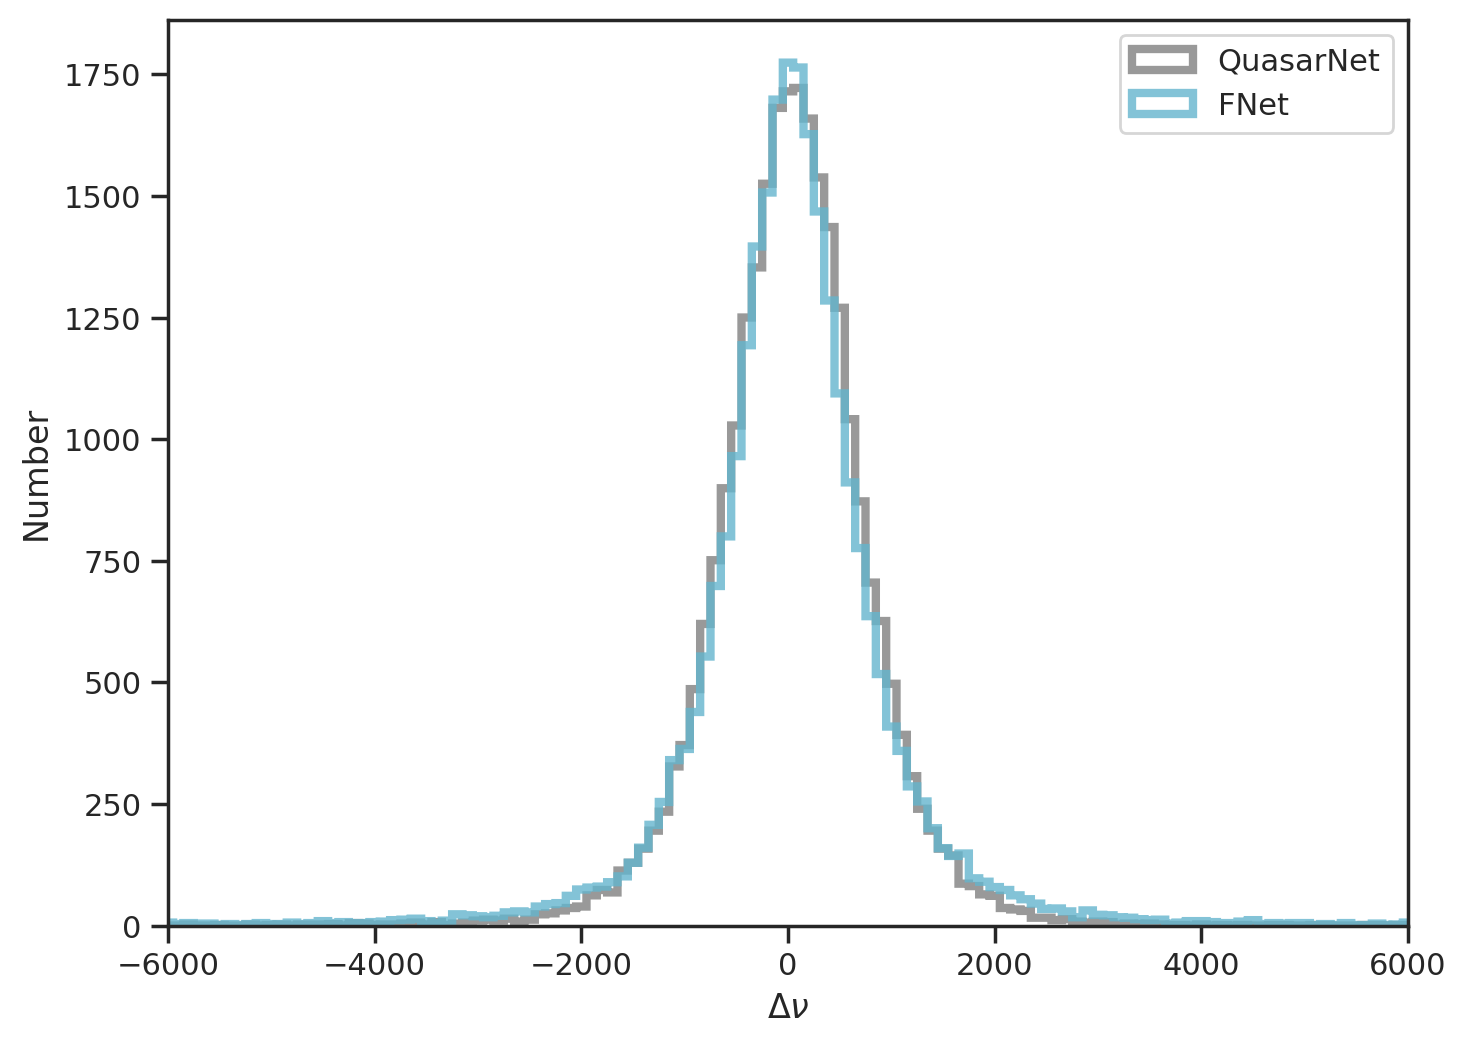

In [283]:
plt.hist(e_Q_same, bins=np.linspace(-5e5,5e5,10000),histtype='step',alpha=0.8,edgecolor='grey',linewidth=3,label='QuasarNet')
plt.hist(e_12, bins=np.linspace(-5e5,5e5,10000),histtype='step',alpha=0.8,edgecolor='C9',linewidth=3,label='FNet')

plt.legend()
plt.xlim(-6000,6000)
#plt.ylim(1,1000)
plt.xlabel(r'$\Delta \nu$',fontsize=12)
plt.ylabel('Number',fontsize=12)

#plt.yscale('log')

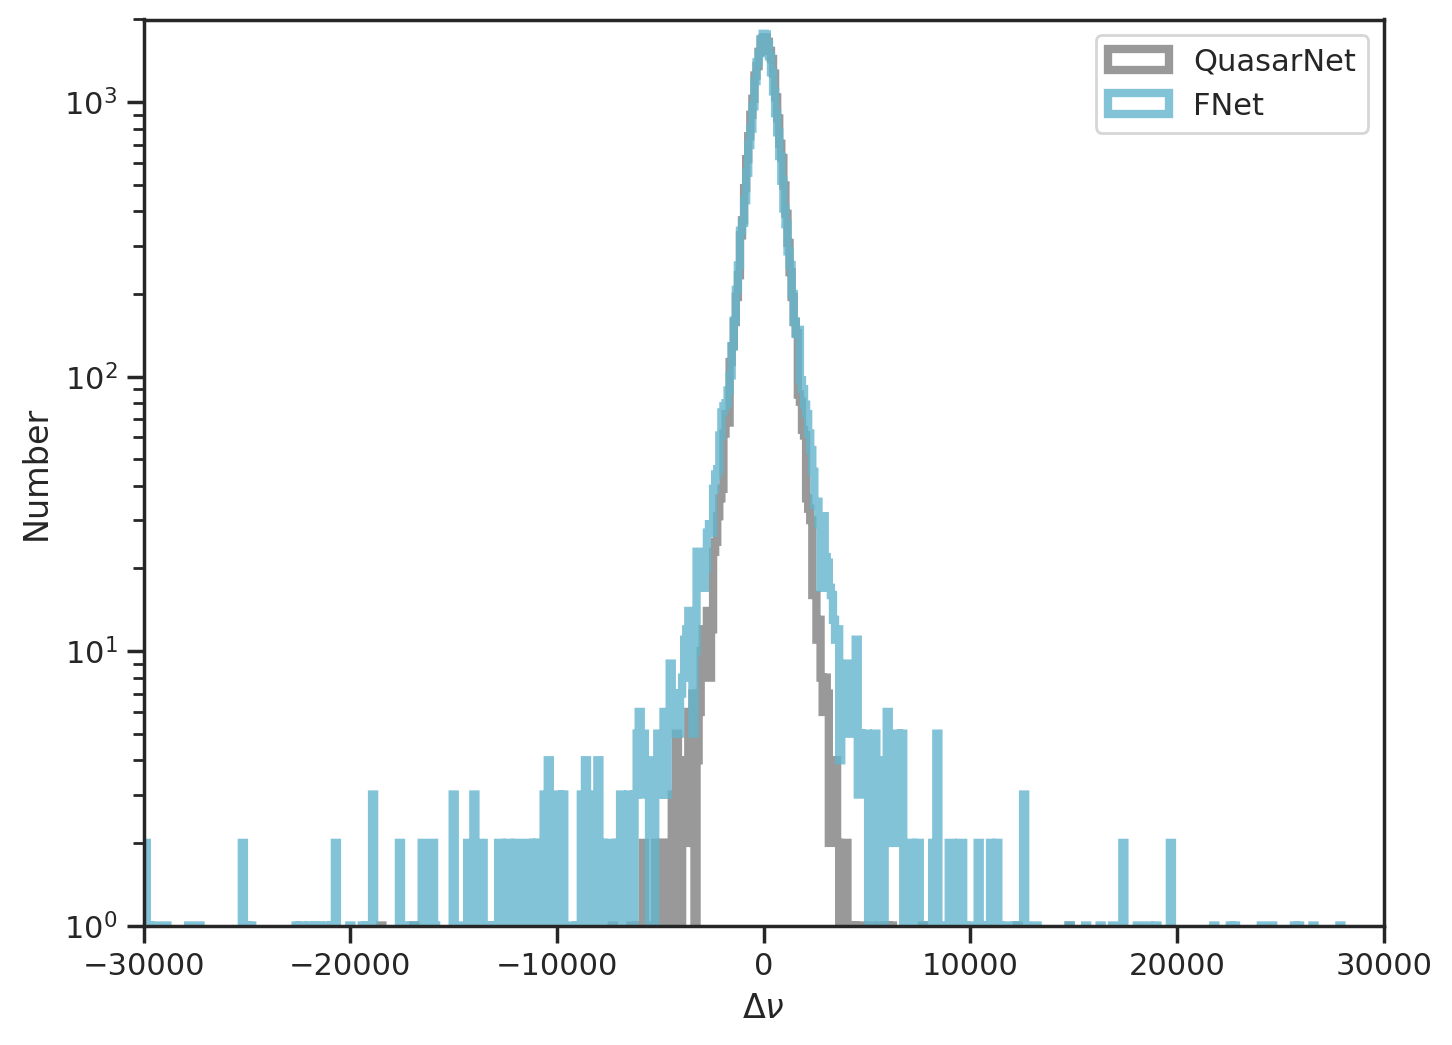

In [286]:
plt.hist(e_Q_same, bins=np.linspace(-5e5,5e5,10000),histtype='step',alpha=0.8,edgecolor='grey',linewidth=3,label='QuasarNet')
plt.hist(e_12, bins=np.linspace(-5e5,5e5,10000),histtype='step',alpha=0.8,edgecolor='C9',linewidth=3,label='FNet')

plt.legend()
plt.xlim(-30000,30000)
plt.ylim(1,2000)
plt.xlabel(r'$\Delta \nu$',fontsize=12)
plt.ylabel('Number',fontsize=12)

plt.yscale('log')

Text(0, 0.5, 'Number')

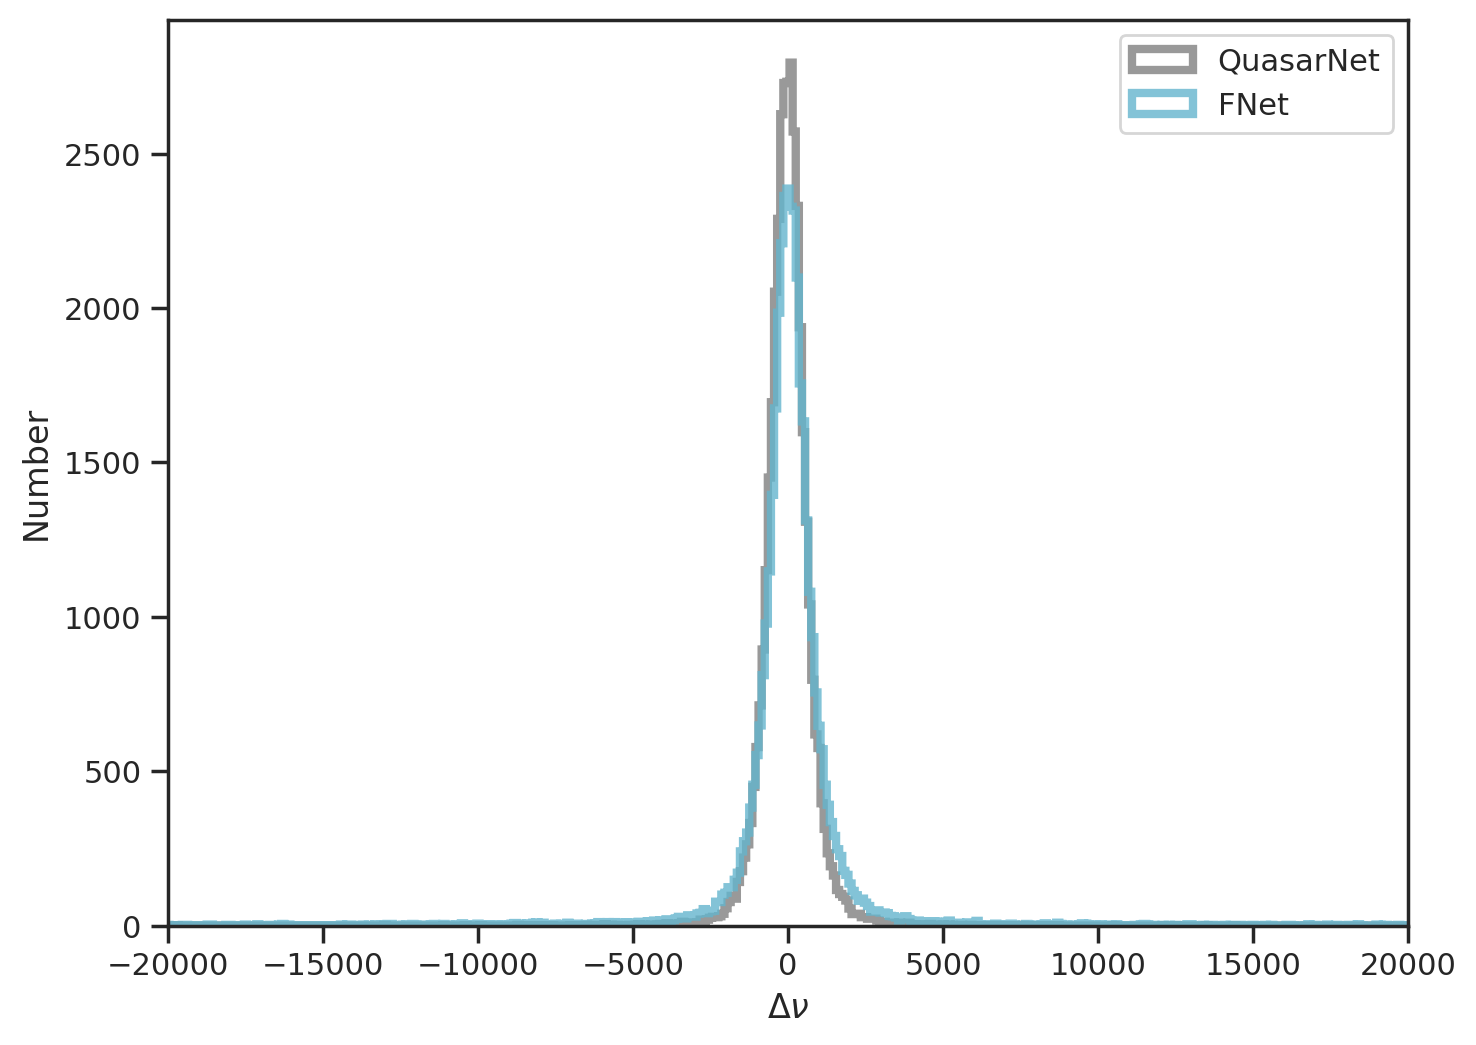

In [294]:
plt.hist(e_Q, bins=np.linspace(-5e5,5e5,10000),histtype='step',alpha=0.8,edgecolor='grey',linewidth=3,label='QuasarNet')
plt.hist(e, bins=np.linspace(-5e5,5e5,10000),histtype='step',alpha=0.8,edgecolor='C9',linewidth=3,label='FNet')

plt.legend()
plt.xlim(-20000,20000)
#plt.ylim(1,1000)
plt.xlabel(r'$\Delta \nu$',fontsize=12)
plt.ylabel('Number',fontsize=12)

#plt.yscale('log')

/home/wangyu/miniconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


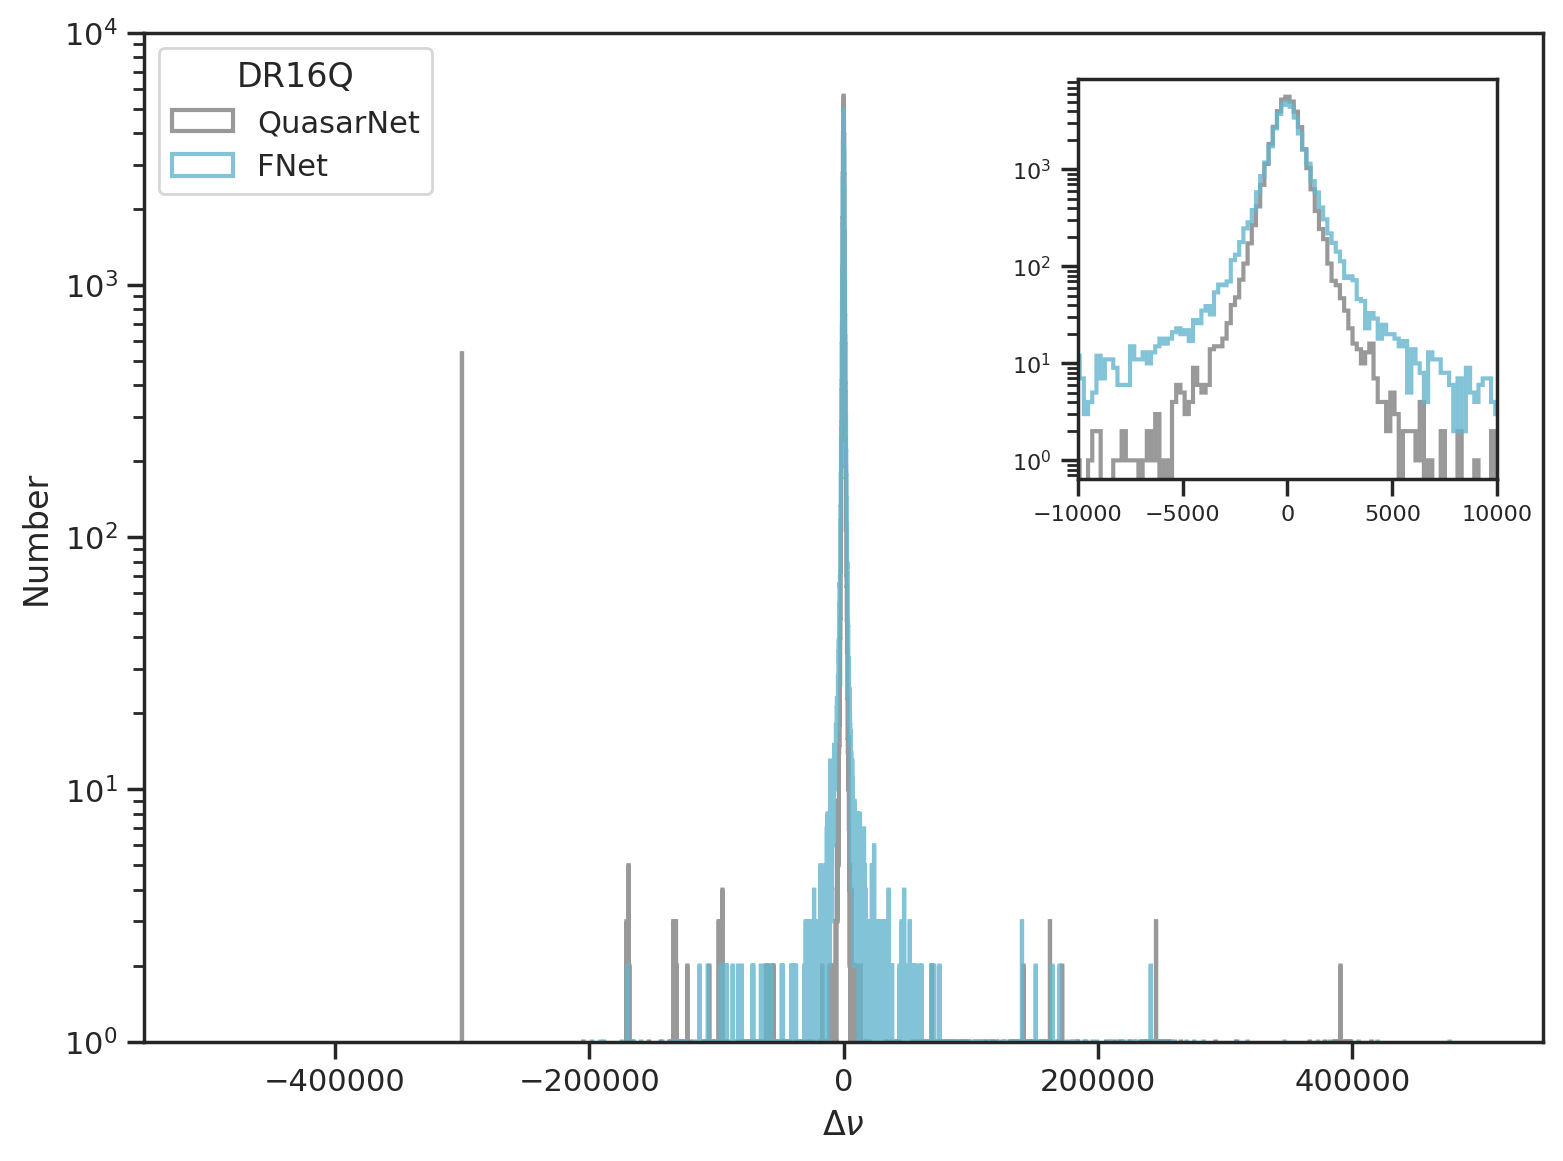

In [168]:
fig, ax = plt.subplots()
e_Q_same = e_Q[torch.randperm(len(e_Q))[:len(e)]]
plt.hist(e_Q_same, bins=np.linspace(-5e5,5e5,5000),histtype='step',alpha=0.8,edgecolor='grey',linewidth=1.5,label='QuasarNet')
plt.hist(e, bins=np.linspace(-5e5,5e5,5000),histtype='step',alpha=0.8,edgecolor='C9',linewidth=1.5,label='FNet')

#plt.hist(e_noZQN, bins=np.linspace(-5e5,5e5,5000),histtype='step',alpha=0.8,edgecolor='C3',linewidth=1.5,label='FNet')



plt.legend(title='DR16Q',loc=2)
#plt.xlim(-420000,420000)
plt.ylim(1,1e4)
#plt.xlim(-6000,6000)

#plt.ylim(1,1000)
plt.xlabel(r'$\Delta \nu$',fontsize=12)
plt.ylabel('Number',fontsize=12)
plt.yscale('log')

from mpl_toolkits.axes_grid.inset_locator import inset_axes
ax_in = inset_axes(ax,
                    width="30%", # width = 30% of parent_bbox
                    height=2., # height : 1 inch
                    borderpad=1.5,
                    loc=1)

ax_in.hist(e_Q_same, bins=np.linspace(-5e5,5e5,5000),histtype='step',alpha=0.8,edgecolor='grey',linewidth=1.5,label='QuasarNet')
ax_in.hist(e, bins=np.linspace(-5e5,5e5,5000),histtype='step',alpha=0.8,edgecolor='C9',linewidth=1.5,label='FNet')
#ax_in.hist(e_noZQN, bins=np.linspace(-5e5,5e5,5000),histtype='step',alpha=0.8,edgecolor='C3',linewidth=1.5,label='FNet')


ax_in.set_xlim(-10000,10000)
#ax_in.set_ylim(1,3e4)
ax_in.set_yscale('log')
ax_in.tick_params(axis='both', which='major', labelsize=8)

fig.tight_layout()
#plt.savefig('DR16Q_Compare.pdf', format='pdf')

In [148]:
e_Q_same = e_Q[torch.randperm(len(e_Q))[:len(e)]]

In [292]:
len(e_Q[e_Q<-50000])

675

/home/wangyu/miniconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


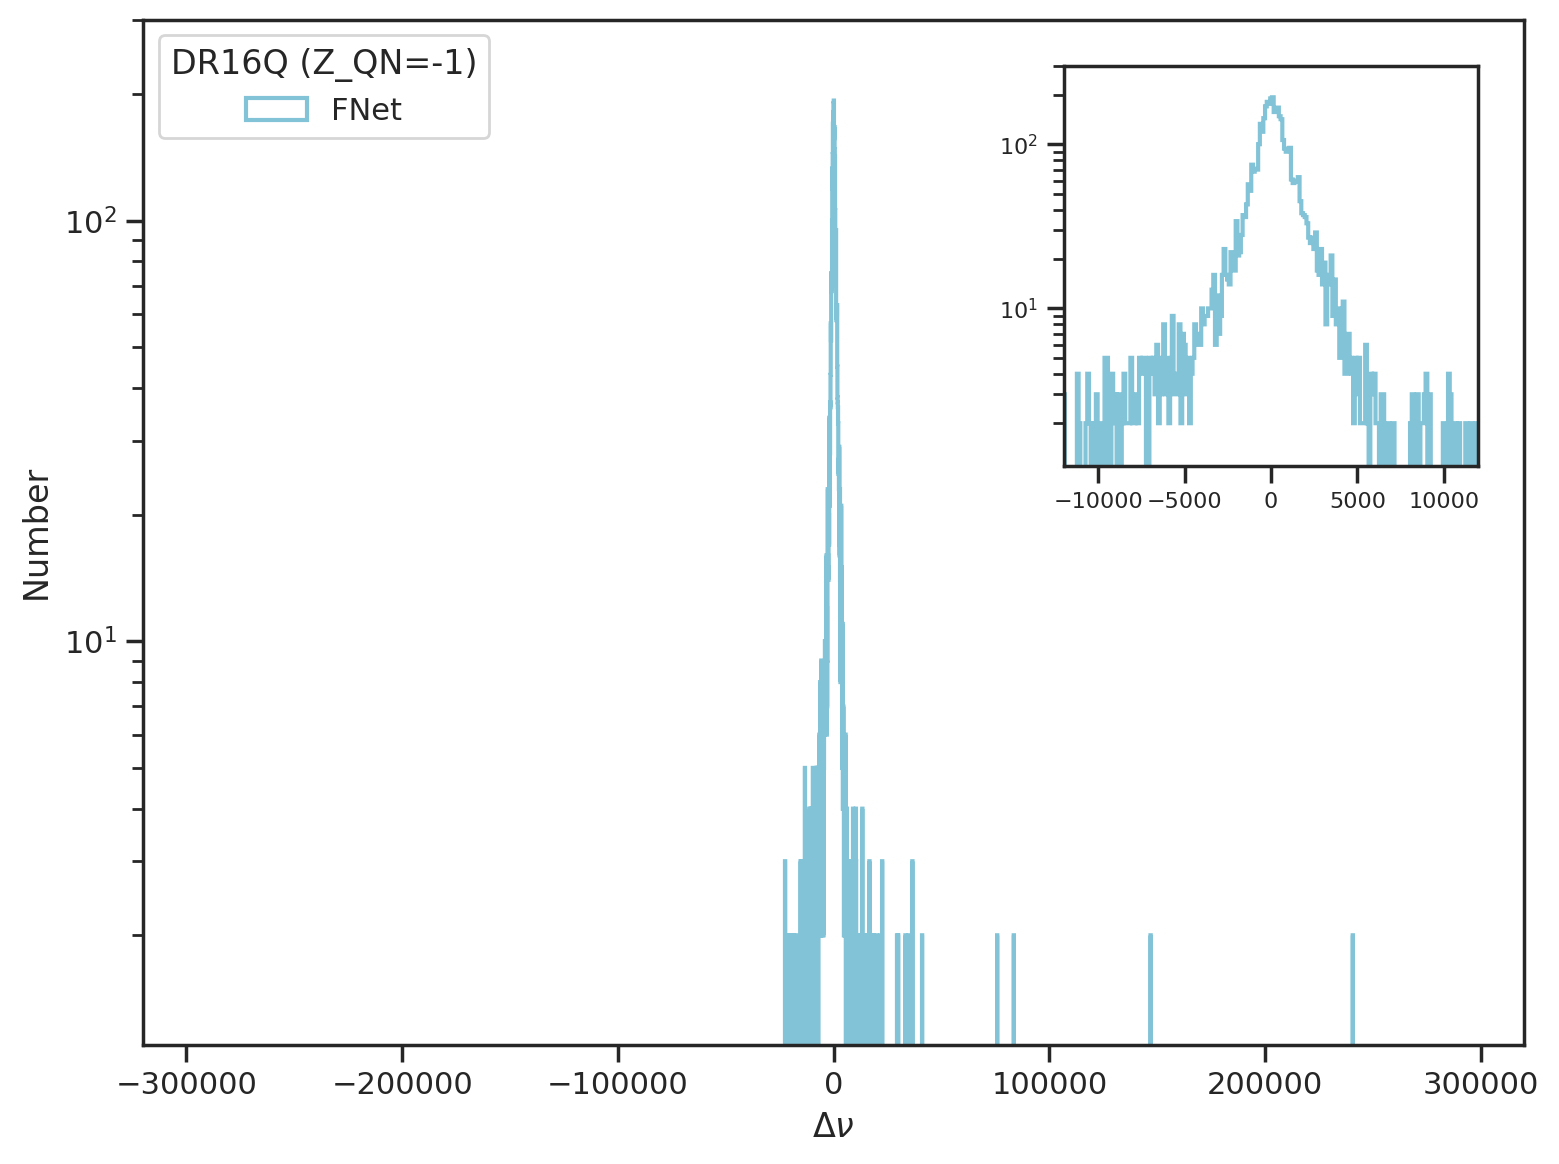

In [332]:
fig, ax = plt.subplots()
plt.hist(e_noZQN, bins=np.linspace(-5e5,5e5,10000),histtype='step',alpha=0.8,edgecolor='C9',linewidth=1.5,label='FNet')

plt.legend(title='DR16Q (Z_QN=-1)',loc=2)
plt.xlim(-320000,320000)
plt.ylim(1.1,300)
#plt.xlim(-6000,6000)

#plt.ylim(1,1000)
plt.xlabel(r'$\Delta \nu$',fontsize=12)
plt.ylabel('Number',fontsize=12)
plt.yscale('log')

from mpl_toolkits.axes_grid.inset_locator import inset_axes
ax_in = inset_axes(ax,
                    width="30%", # width = 30% of parent_bbox
                    height=2., # height : 1 inch
                    borderpad=1.5,
                    loc=1)

ax_in.hist(e_noZQN, bins=np.linspace(-5e5,5e5,10000),histtype='step',alpha=0.8,edgecolor='C9',linewidth=1.5,label='FNet')
ax_in.set_xlim(-12000,12000)
ax_in.set_ylim(1.1,300)
ax_in.set_yscale('log')
ax_in.tick_params(axis='both', which='major', labelsize=8)

fig.tight_layout()
plt.savefig('DR16Q_noZQN.pdf', format='pdf')

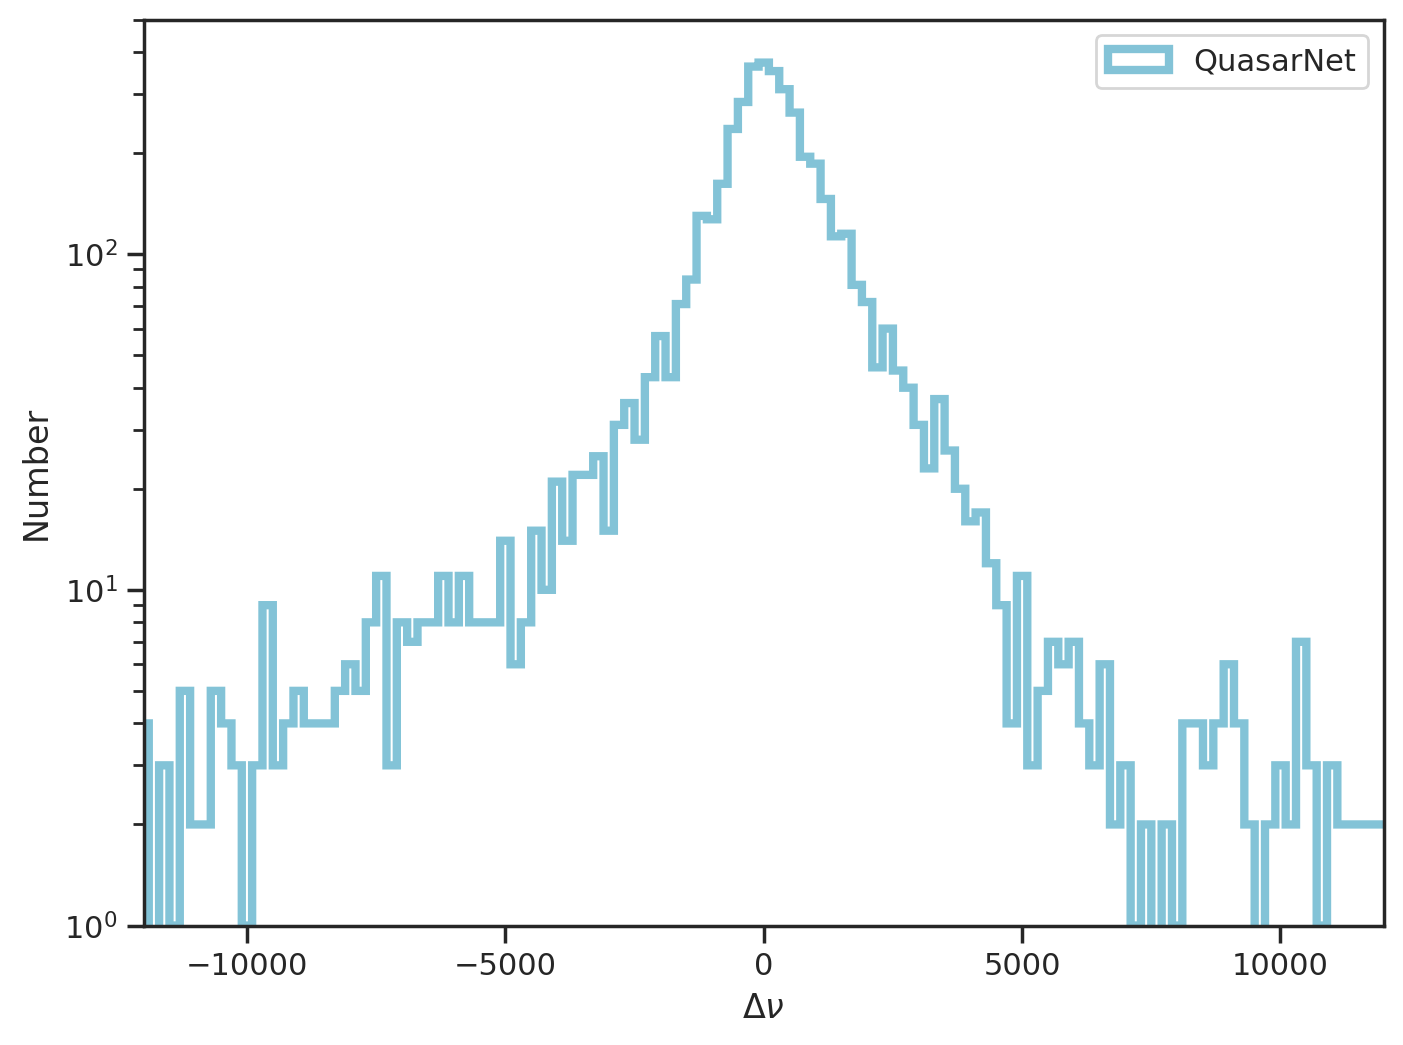

In [239]:
plt.hist(e_noZQN, bins=np.linspace(-5e5,5e5,5000),histtype='step',alpha=0.8,edgecolor='C9',linewidth=3,label='QuasarNet')

plt.legend()
plt.xlim(-12000,12000)
plt.ylim(1,5e_Q)
plt.xlabel(r'$\Delta \nu$',fontsize=12)
plt.ylabel('Number',fontsize=12)

plt.yscale('log')

fig.tight_layout()
plt.savefig('Z_QN_-1.pdf', format='pdf')

Text(0, 0.5, 'Number')

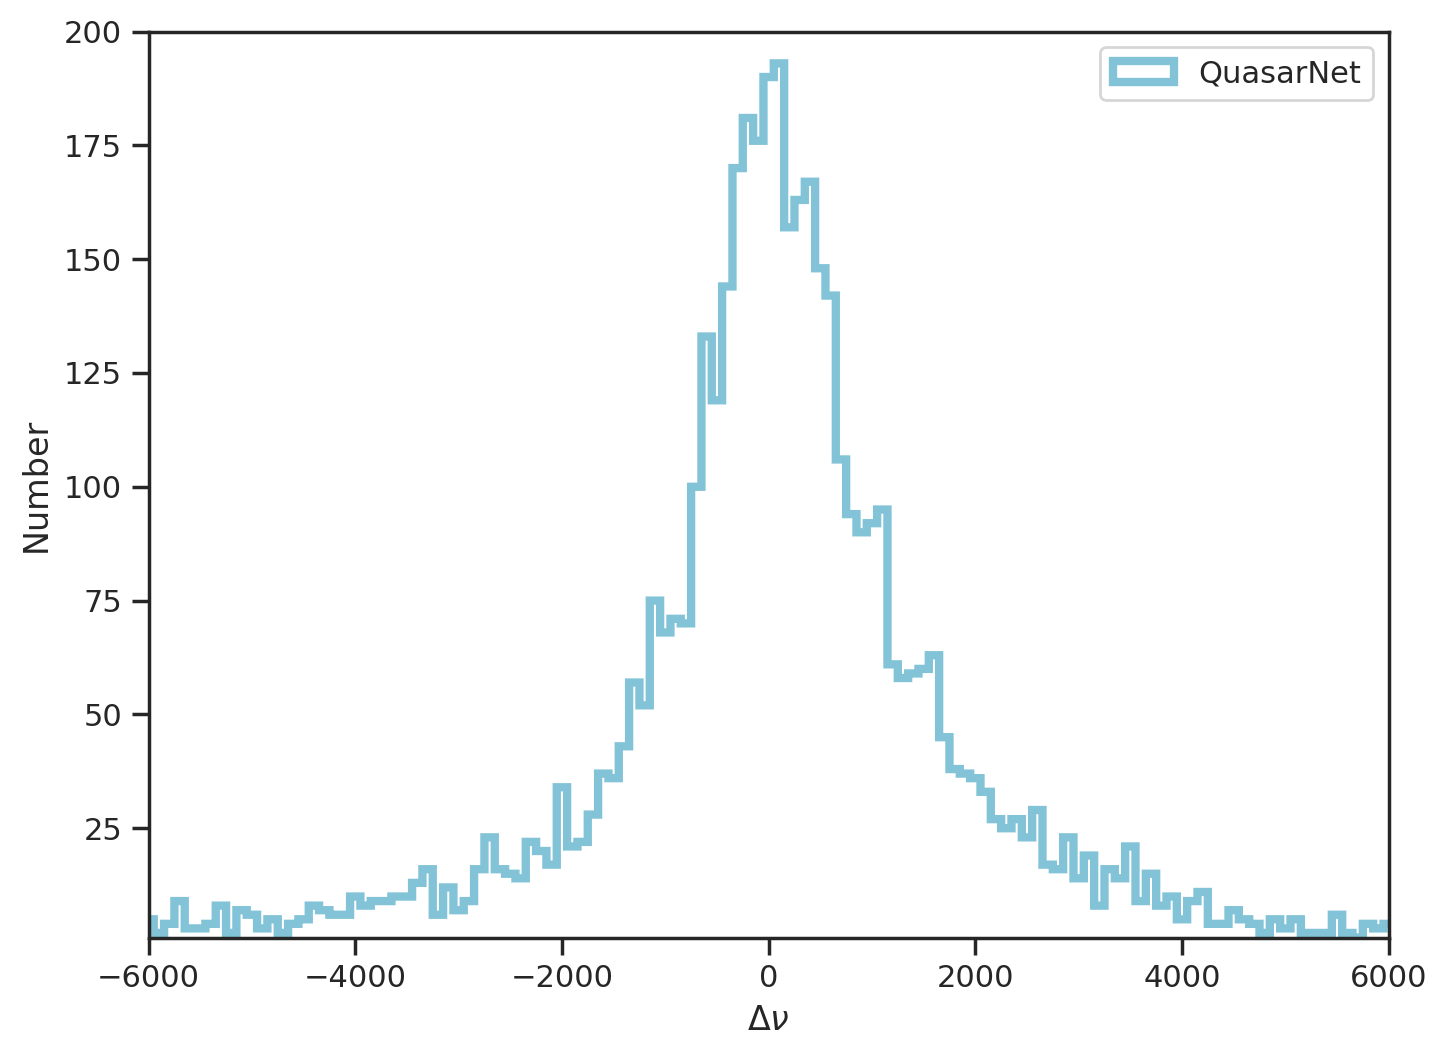

In [229]:
plt.hist(e_noZQN, bins=np.linspace(-5e5,5e5,5000),histtype='step',alpha=0.8,edgecolor='C9',linewidth=3,label='QuasarNet')

plt.legend()
plt.xlim(-6000,6000)
plt.ylim(1,200)
plt.xlabel(r'$\Delta \nu$',fontsize=12)
plt.ylabel('Number',fontsize=12)

#plt.yscale('log')

In [76]:
e_Q_16[torch.randperm(len(e_Q_16))[:len(e_16)]]

array([ -989.55463618,   502.25271843,  -552.14599706, ...,
         226.78896203,  -485.30803761, -1094.25731935])

In [72]:
e_Q_16[torch.randperm(len(e_Q_16))[len(e_16)]]

54.4444119441323

/home/wangyu/miniconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


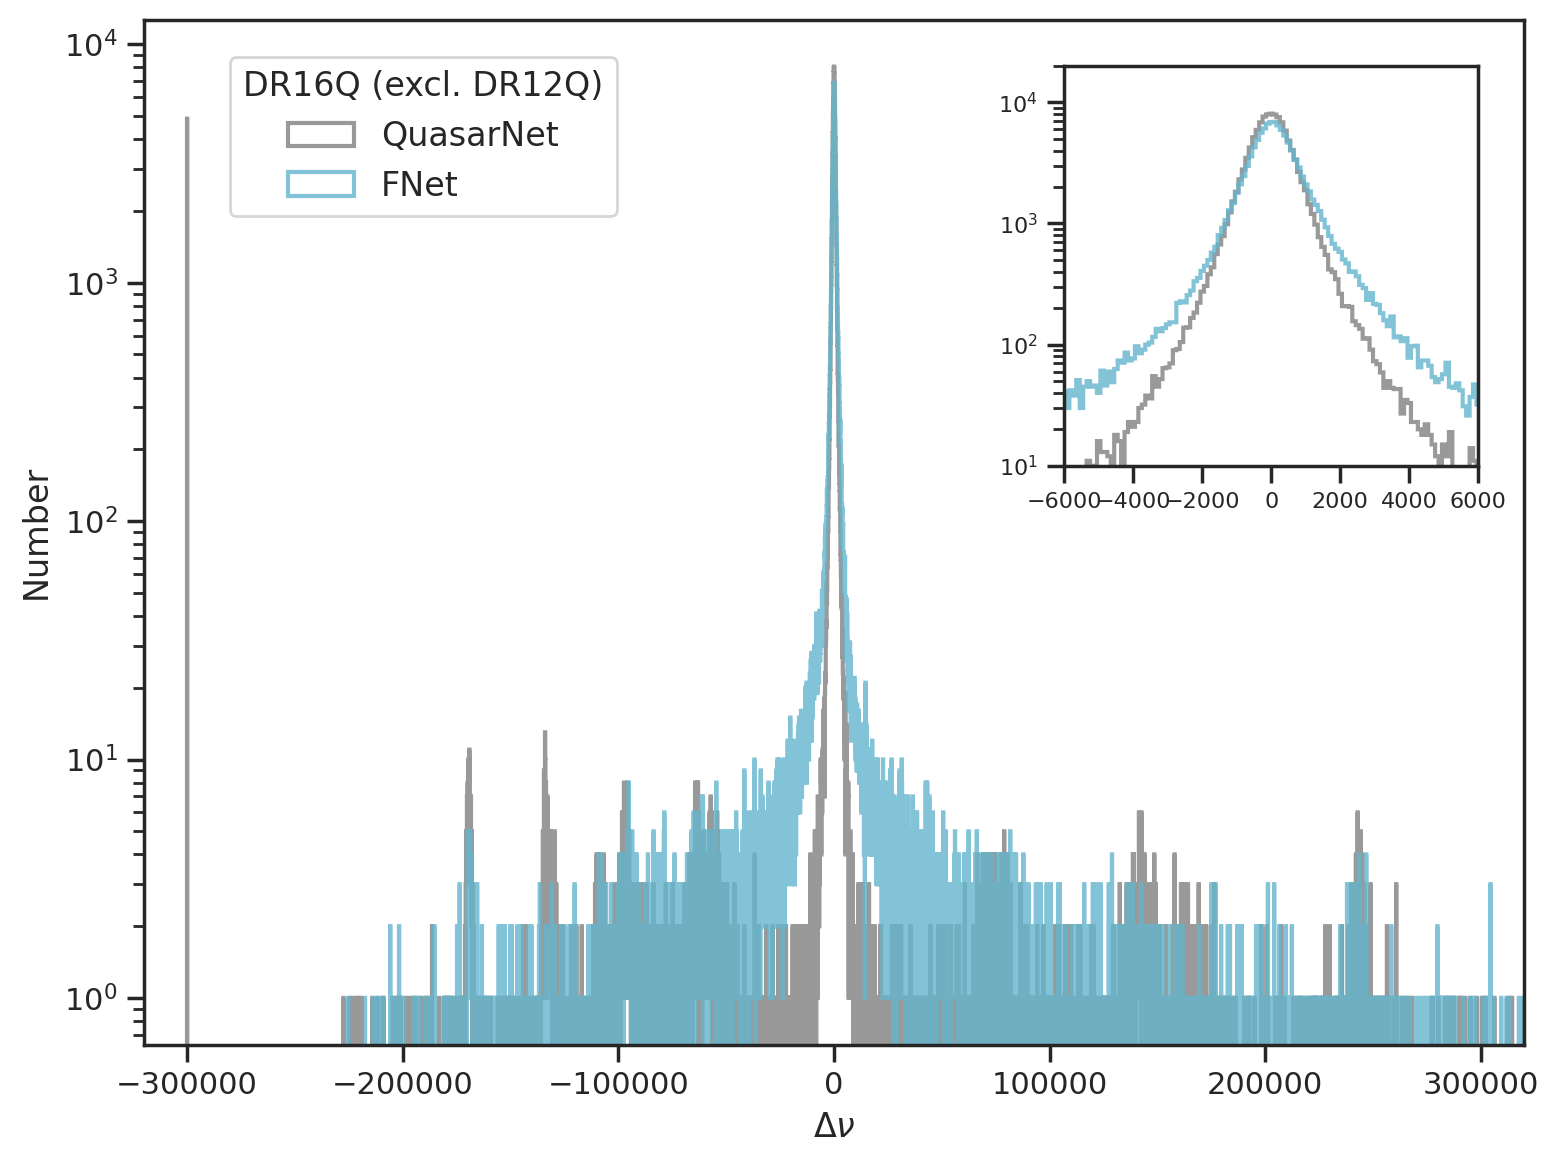

In [324]:
fig, ax = plt.subplots()
#e_Q_16_samesize = e_Q_16[torch.randperm(len(e_Q_16))[:len(e_16)]]
plt.hist(e_Q_16, bins=np.linspace(-5e5,5e5,10000),histtype='step',alpha=0.8,edgecolor='grey',linewidth=1.5,label='QuasarNet')
plt.hist(e_16, bins=np.linspace(-5e5,5e5,10000),histtype='step',alpha=0.8,edgecolor='C9',linewidth=1.5,label='FNet')

#plt.hist(e_noZQN, bins=np.linspace(-5e5,5e5,2500),histtype='step',alpha=0.8,edgecolor='C3',linewidth=1.5,label='FNet')


plt.legend(title='DR16Q (excl. DR12Q)',loc=2, bbox_to_anchor=(0.05, 0.98, 0, 0), prop={'size': 12})
plt.xlim(-320000,320000)
#plt.ylim(1,2e3)
#plt.xlim(-6000,6000)

#plt.ylim(1,1000)
plt.xlabel(r'$\Delta \nu$',fontsize=12)
plt.ylabel('Number',fontsize=12)
plt.yscale('log')

from mpl_toolkits.axes_grid.inset_locator import inset_axes
ax_in = inset_axes(ax,
                    width="30%", # width = 30% of parent_bbox
                    height=2., # height : 1 inch
                    borderpad=1.5,
                    loc=1)

ax_in.hist(e_Q_16, bins=np.linspace(-5e5,5e5,10000),histtype='step',alpha=0.8,edgecolor='grey',linewidth=1.5,label='QuasarNet')
ax_in.hist(e_16, bins=np.linspace(-5e5,5e5,10000),histtype='step',alpha=0.8,edgecolor='C9',linewidth=1.5,label='FNet')
#ax_in.hist(e_noZQN, bins=np.linspace(-5e5,5e5,2500),histtype='step',alpha=0.8,edgecolor='C3',linewidth=1.5,label='FNet')


ax_in.set_xlim(-6000,6000)
ax_in.set_ylim(10,2e4)
ax_in.set_yscale('log')
ax_in.tick_params(axis='both', which='major', labelsize=8)

fig.tight_layout()
plt.savefig('DR16QOnly_Compare.pdf', format='pdf')

/home/wangyu/miniconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


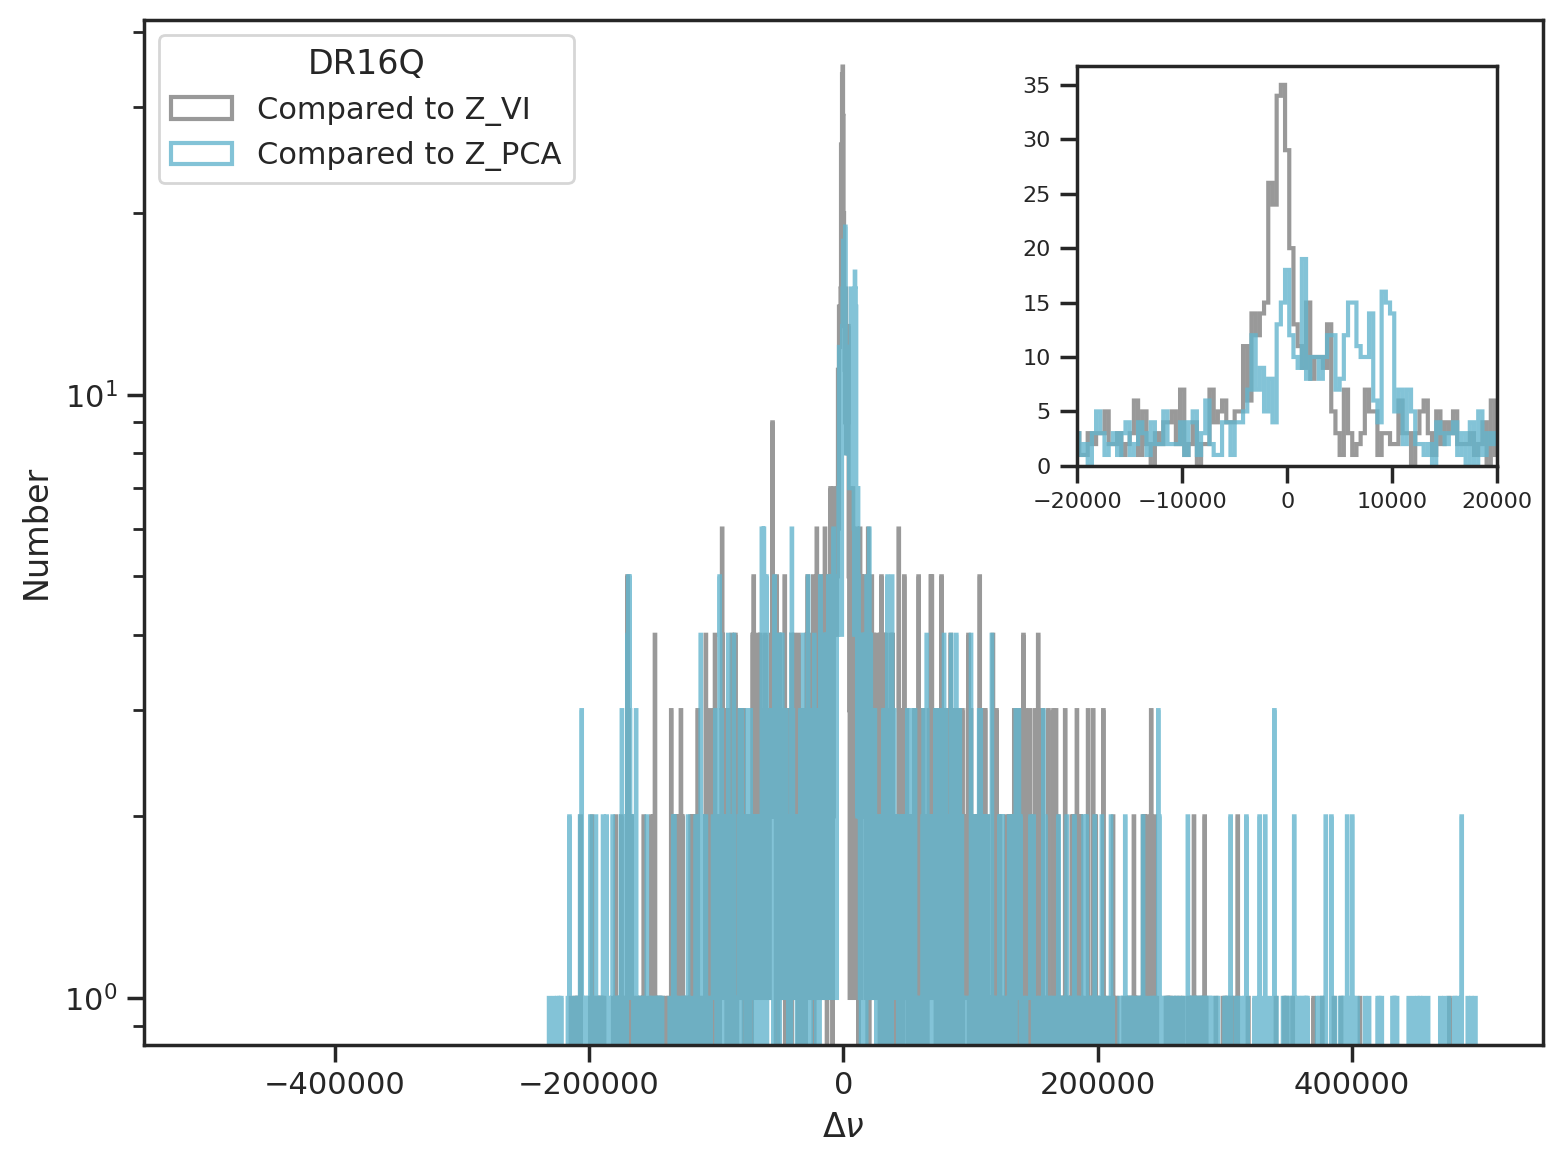

In [237]:
fig, ax = plt.subplots()
plt.hist(e_PCA_VI_VI, bins=np.linspace(-5e5,5e5,2500),histtype='step',alpha=0.8,edgecolor='grey',linewidth=1.5,label='Compared to Z_VI')
plt.hist(e_PCA_VI_PCA, bins=np.linspace(-5e5,5e5,2500),histtype='step',alpha=0.8,edgecolor='C9',linewidth=1.5,label='Compared to Z_PCA')

#plt.hist(e_noZQN, bins=np.linspace(-5e5,5e5,5000),histtype='step',alpha=0.8,edgecolor='C3',linewidth=1.5,label='FNet')



plt.legend(title='DR16Q',loc=2)
#plt.xlim(-320000,320000)
#plt.ylim(1,2e4)
#plt.xlim(-6000,6000)

#plt.ylim(1,1000)
plt.xlabel(r'$\Delta \nu$',fontsize=12)
plt.ylabel('Number',fontsize=12)
plt.yscale('log')

from mpl_toolkits.axes_grid.inset_locator import inset_axes
ax_in = inset_axes(ax,
                    width="30%", # width = 30% of parent_bbox
                    height=2., # height : 1 inch
                    borderpad=1.5,
                    loc=1)

ax_in.hist(e_PCA_VI_VI, bins=np.linspace(-5e5,5e5,2500),histtype='step',alpha=0.8,edgecolor='grey',linewidth=1.5,label='QuasarNet')
ax_in.hist(e_PCA_VI_PCA, bins=np.linspace(-5e5,5e5,2500),histtype='step',alpha=0.8,edgecolor='C9',linewidth=1.5,label='FNet')
#ax_in.hist(e_noZQN, bins=np.linspace(-5e5,5e5,5000),histtype='step',alpha=0.8,edgecolor='C3',linewidth=1.5,label='FNet')


ax_in.set_xlim(-20000,20000)
#ax_in.set_ylim(1,3e4)
ax_in.set_yscale('linear')
ax_in.tick_params(axis='both', which='major', labelsize=8)

fig.tight_layout()
#plt.savefig('DR16Q_Compare.pdf', format='pdf')

In [92]:
np.arange()

129725

In [231]:
inv_norm(Z_VI_12, b_PCA_VI_VI)

array([1.0169212, 1.3316656, 1.2948259, ..., 1.1067612, 2.4126654,
       1.5245589], dtype=float32)

In [233]:
inv_norm(Z_VI_12, c_PCA_VI_VI)

array([4.016    , 0.93821  , 1.9330001, ..., 2.15246  , 2.37     ,
       1.516    ], dtype=float32)

In [232]:
inv_norm(Z_VI_12, b_PCA_VI_PCA)

array([0.848515  , 1.1106386 , 0.88546664, ..., 2.016612  , 1.0741415 ,
       1.6829376 ], dtype=float32)

In [234]:
inv_norm(Z_VI_12, c_PCA_VI_PCA)

array([0.01286101, 0.00919022, 3.5422983 , ..., 0.6538873 , 2.031797  ,
       0.8077137 ], dtype=float32)

In [211]:
len(e)

39684

In [231]:
len(e[np.abs(e)<6000])/len(e)

0.9691815341195444

In [232]:
len(e[np.abs(e)<12000])/len(e)

0.9802691260961597

In [233]:
len(e[np.abs(e)<30000])/len(e)

0.9886604172966434

In [230]:
len(e_Q[np.abs(e_Q)<6000])/len(e_Q)

0.9776232234653764

(array([3.2000e+01, 2.0000e+00, 1.0000e+01, 1.0000e+00, 2.6652e+04,
        2.0000e+00, 4.0000e+00, 5.0000e+00, 0.0000e+00, 3.0000e+00]),
 array([-30000.    , -23107.262 , -16214.521 ,  -9321.783 ,  -2429.0437,
          4463.6953,  11356.435 ,  18249.174 ,  25141.912 ,  32034.652 ,
         38927.39  ], dtype=float32),
 <BarContainer object of 10 artists>)

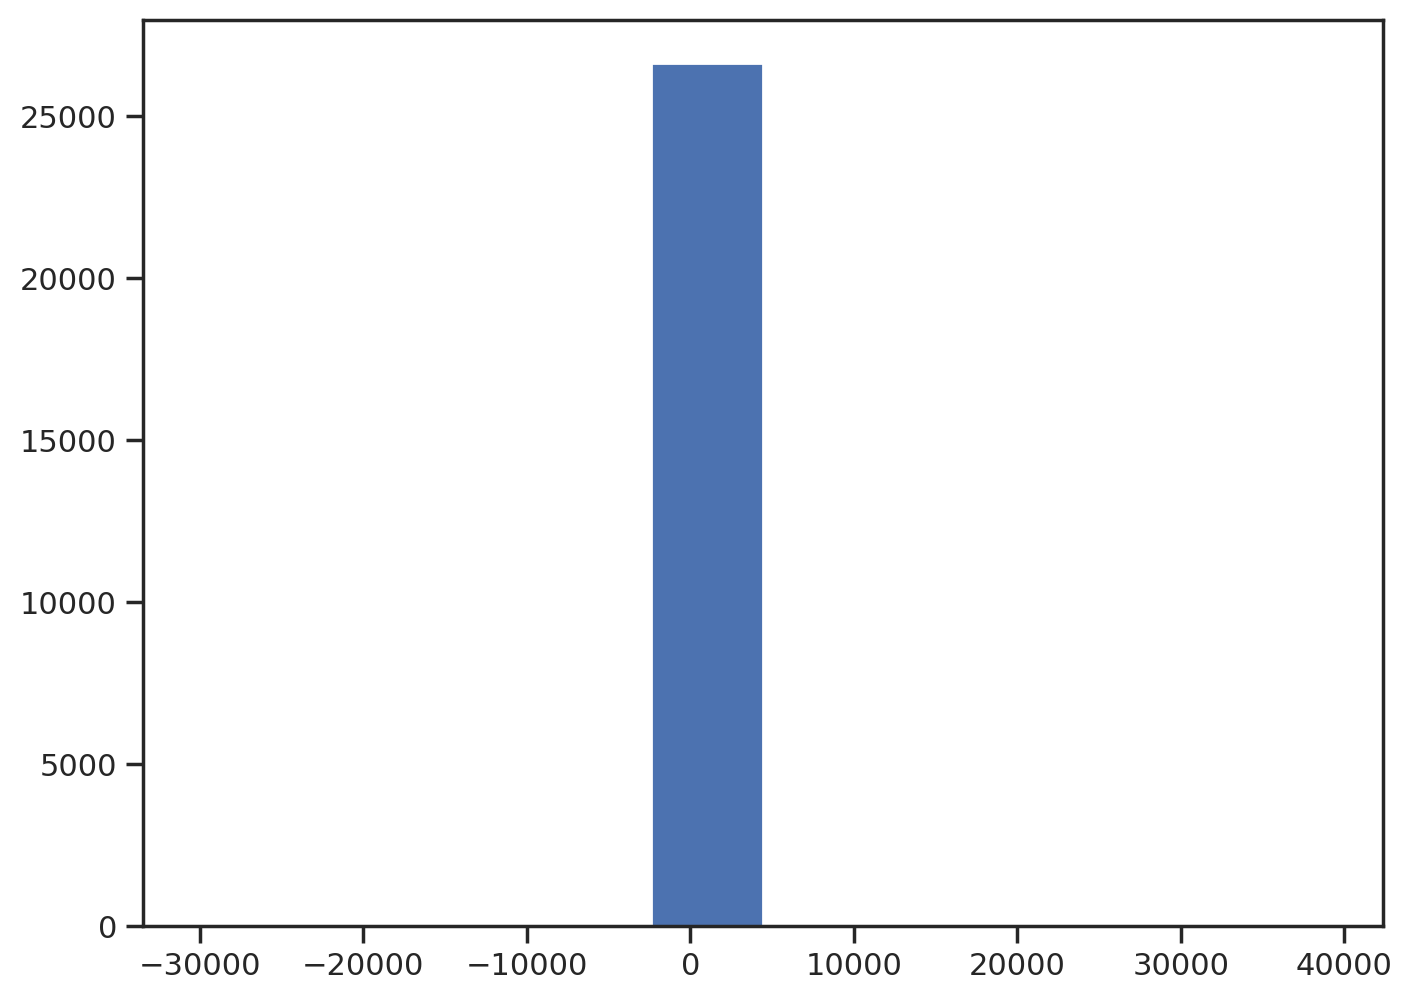

In [44]:
plt.hist(e_Q)

In [ ]:
valid_loss_1 = net1.history[:,'valid_loss']
valid_loss_2 = net2.history[:,'valid_loss']
valid_loss_3 = net3.history[:,'valid_loss']
valid_loss_4 = net4.history[:,'valid_loss']

In [ ]:
train_loss_1 = net1.history[:,'train_loss'] 
train_loss_2 = net2.history[:,'train_loss']    
train_loss_3 = net3.history[:,'train_loss']   
train_loss_4 = net4.history[:,'train_loss']

In [ ]:
trainloss=np.concatenate((train_loss_1,train_loss_2,train_loss_3,train_loss_4), axis=0)
validloss=np.concatenate((valid_loss_1,valid_loss_2,valid_loss_3,valid_loss_4), axis=0)

In [ ]:
#trainloss=np.concatenate((train_loss_1,train_loss_2,train_loss_3,train_loss), axis=0)
#validloss=np.concatenate((valid_loss_1,valid_loss_2,valid_loss_3,valid_loss), axis=0)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.xlabel('Epoches')
plt.ylabel('validaton loss, train loss')
plt.plot(trainloss,linewidth=5.5)
plt.plot(validloss,linewidth=5.5)
#plt.xlim(0.1,7.1)
plt.ylim(-0.01,0.51)
plt.show()

In [ ]:
#import matplotlib.pyplot as plt
#%matplotlib inline 
#plt.xlabel('Epoches')
#plt.ylabel('validaton loss, train loss')
#plt.semilogy(trainloss,linewidth=1)
#plt.semilogy(validloss,linewidth=1)
#plt.xlim(0.1,7.1)
#plt.ylim(-0.01,0.51)
#plt.show()

In [ ]:
Y_pred = net4.predict(X_test)

In [ ]:
import matplotlib.pyplot as plt
#labels_norm = (Y - label_mean)/label_std

Z = Y_pred*label_std+label_mean
y = Y_test*label_std+label_mean

plt.figure(figsize=(10,7))

x1=np.linspace(0,5.7,9)
y1=x1
y2=(1+x1)/10 +x1
y3=-(1+x1)/10 +x1

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(y, Z, s=5, c='b', marker="s",label='FNet',alpha=0.5)
ax1.scatter(y, Y_test1, s=10, c='r', marker="o",label='QuasarNet',alpha=0.5)
ax1.scatter(y, Y_test3, s=10, c='g', marker="o",label='PCA',alpha=0.5)
for i in range(len(y)):
    if (abs(Z[i].item()-y[i].item()) > abs(Y_test1[i].item()-y[i].item())):
        color = 'b'
    else:
        color = 'r'
    plt.plot([y[i],y[i]], [Z[i], Y_test1[i]], '-', color=color, markersize=3,lw=0.5,alpha=0.3)

plt.plot(x1,y1)
#plt.plot(x1,y2)
#plt.plot(x1,y3)
plt.legend(fontsize=12)
plt.xlabel('Visual Redshift', fontsize=12)
plt.ylabel('Predicted Redshift', fontsize=12)
plt.xlim(0.0,5.7)
plt.ylim(-2,6)
plt.yticks(fontsize=12) 
plt.xticks(fontsize=12) 
plt.grid()
plt.show()

In [ ]:
_ = plt.hist(Z,np.linspace(0,5,100),alpha=1, label='FNet')
#_ = plt.hist(Y_test.numpy(),np.linspace(0,5,100),alpha=0.5, label='VI')
_ = plt.hist(Y_test1.numpy(),np.linspace(0,5,100),alpha=0.5, label='QuasarNet')


#_ = plt.hist(Y_test2.numpy(),np.linspace(0,5,100),alpha=0.6)
#_ = plt.hist(Y_test3.numpy(),np.linspace(0,5,100),alpha=0.6)
plt.legend()

In [ ]:
REL=300000*(Z-y.numpy())/(1+y.numpy())
REL1=300000*(Y_test1.numpy()-y.numpy())/(1+y.numpy())
REL2=300000*(Y_test2.numpy()-y.numpy())/(1+y.numpy())
REL3=300000*(Y_test3.numpy()-y.numpy())/(1+y.numpy())
print(abs(REL).mean(),REL.mean())
print(abs(REL1).mean(),REL1.mean())
print(abs(REL2).mean(),REL2.mean())
print(abs(REL3).mean(),REL3.mean())

In [ ]:
import pandas as pd
df = pd.DataFrame(list(zip(Y_test1.view(-1).numpy(),y.view(-1).numpy())),
                  columns = ['Y_test1', 'y'])
df = df[df['Y_test1']>0]
REL1_VI=(300000*(df['Y_test1']-df['y'])/(1+df['y'])).tolist()

In [ ]:
plt.plot()

In [ ]:
for i in range(len(REL1)):
    if ((abs(REL[i])>30000)):
        print(y.numpy()[i],Y_test1[i],Z[i], file=open("Error1.txt", "a"))

In [ ]:
for i in range(len(REL1)):
    if ((abs(REL[i])<6000)):
        print(i, file=open("Rahim.txt", "a"))

In [ ]:
file = open('Rahim.txt', "r+")
file.truncate()
for i in range(len(REL)):
    if ((y.numpy()[i]>2.0)):
        print(i, file=open("Rahim.txt", "a"))
        
with open("Rahim.txt","r") as f:
    print(len(f.readlines()))

In [ ]:
file = open('Rahim.txt', "r+")
file.truncate()
for i in range(len(REL)):
    if ((abs(REL[i])<6000)):
        print(i, file=open("Rahim.txt", "a"))
        
with open("Rahim.txt","r") as f:
    print(len(f.readlines())/len(REL))

In [ ]:
file = open('Rahim.txt', "r+")
file.truncate()
for i in range(len(REL)):
    if ((abs(REL1[i])<12000)):
        print(i, file=open("Rahim.txt", "a"))
        
with open("Rahim.txt","r") as f:
    print(len(f.readlines())/len(REL))

In [ ]:
file = open('Rahim.txt', "r+")
file.truncate()
for i in range(len(REL)):
    if ((abs(REL2[i])<6000)):
        print(i, file=open("Rahim.txt", "a"))
        
with open("Rahim.txt","r") as f:
    print(len(f.readlines())/len(REL))

In [ ]:
file = open('Rahim.txt', "r+")
file.truncate()
for i in range(len(REL)):
    if ((abs(REL3[i])<6000)):
        print(i, file=open("Rahim.txt", "a"))
        
with open("Rahim.txt","r") as f:
    print(len(f.readlines())/len(REL))

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import pyplot
#pyplot.yscale('log')
data = REL
plt.figure(figsize=(10,7))



plt.hist(data, bins=np.linspace(-0.25e6,0.75e6,100),histtype='step',alpha=0.8,edgecolor='b',linewidth=2,label='FNet ('+str(len(data))+')')
plt.hist(REL1_VI, bins=np.linspace(-0.25e6,0.75e6,100),histtype='step',alpha=0.8,edgecolor='r',linewidth=2,label='QuasarNet ('+str(len(REL1_VI))+')')
#plt.hist(REL2, bins=6000,histtype='step',alpha=0.3,edgecolor='g',linewidth=2,label='ZPIPW')
#plt.hist(REL3, bins=9000,histtype='step',alpha=0.3,edgecolor='black',linewidth=2,label='PCA')
plt.yscale('log')

plt.ylabel('QSO number', fontsize=12)
plt.yticks(fontsize=12) 

plt.xlabel(' ∆ν', fontsize=12)
plt.xticks(fontsize=12) 


#plt.xlim(-0.5e6,0.3e6)
plt.legend(loc='best', fontsize=12) 
#plt.ylim(0,2)
#plt.savefig('FNet.pdf')
plt.show() 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import pyplot
#pyplot.yscale('log')
data = REL
plt.figure(figsize=(10,7))



plt.hist(data, bins=np.linspace(-0.1e6,0.1e6,100),histtype='step',alpha=0.8,edgecolor='b',linewidth=2,label='FNet ('+str(len(data))+')')
plt.hist(REL1_VI, bins=np.linspace(-0.1e6,0.1e6,100),histtype='step',alpha=0.8,edgecolor='r',linewidth=2,label='QuasarNet ('+str(len(REL1_VI))+')')
#plt.hist(REL2, bins=6000,histtype='step',alpha=0.3,edgecolor='g',linewidth=2,label='ZPIPW')
#plt.hist(REL3, bins=9000,histtype='step',alpha=0.3,edgecolor='black',linewidth=2,label='PCA')
#plt.yscale('log')

plt.ylabel('QSO number', fontsize=12)
plt.yticks(fontsize=12) 

plt.xlabel(' ∆ν', fontsize=12)
plt.xticks(fontsize=12) 


#plt.xlim(-0.5e6,0.3e6)
plt.legend(loc='best', fontsize=12) 
#plt.ylim(0,2)
#plt.savefig('FNet.pdf')
plt.show() 

In [ ]:
torch.save(net.state_dict(), runs_path+'CNN-cv-main-DR12Q-63000-ResNet-24-for-all-10epoches.pt')

In [ ]:
net()

In [ ]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import pyplot
#pyplot.yscale('log')
data = REL
plt.figure(figsize=(10,7))

sns.set_style('white')

plt.hist(data, bins=10000,histtype='step',alpha=0.8,edgecolor='b',linewidth=2,label='FNet')
plt.hist(REL1, bins=10000,histtype='step',alpha=0.8,edgecolor='r',linewidth=2,label='QuasarNet')
#plt.hist(REL2, bins=6000,histtype='step',alpha=0.3,edgecolor='g',linewidth=2,label='ZPIPW')
plt.hist(REL3, bins=20000,histtype='step',alpha=0.3,edgecolor='black',linewidth=2,label='PCA')

plt.ylabel('QSO number', fontsize=20)
plt.yticks(fontsize=20) 

plt.xlabel(' ∆ν', fontsize=20)
plt.xticks(fontsize=20) 


plt.xlim(-6000,6000)
plt.legend(loc='best', fontsize=20) 
#plt.ylim(0,7)
#plt.savefig('FNet.pdf')
plt.show() 


In [24]:
e_PCA = 300000*((inv_norm(Z_VI_12, Z_PCA) - inv_norm(Z_VI_12, Z_VI))/(1+inv_norm(Z_VI_12, Z_VI)))
print(abs(e_PCA).mean(),e_PCA.mean(),np.median(abs(e_PCA)))

1235.2525680624567 -13.84779423196791 280.050456058234


In [28]:
len(e_PCA[np.abs(e_PCA)<6000])/len(e_PCA)

0.9941713223009291

In [53]:
aa = Z_QN[Z_DR12Q==-1]

In [57]:
len(Z_QN_16[Z_QN_16==-1])

4872

In [58]:
e_Q_16.min()

-1583694.7917938232

(90.0, 100.0)

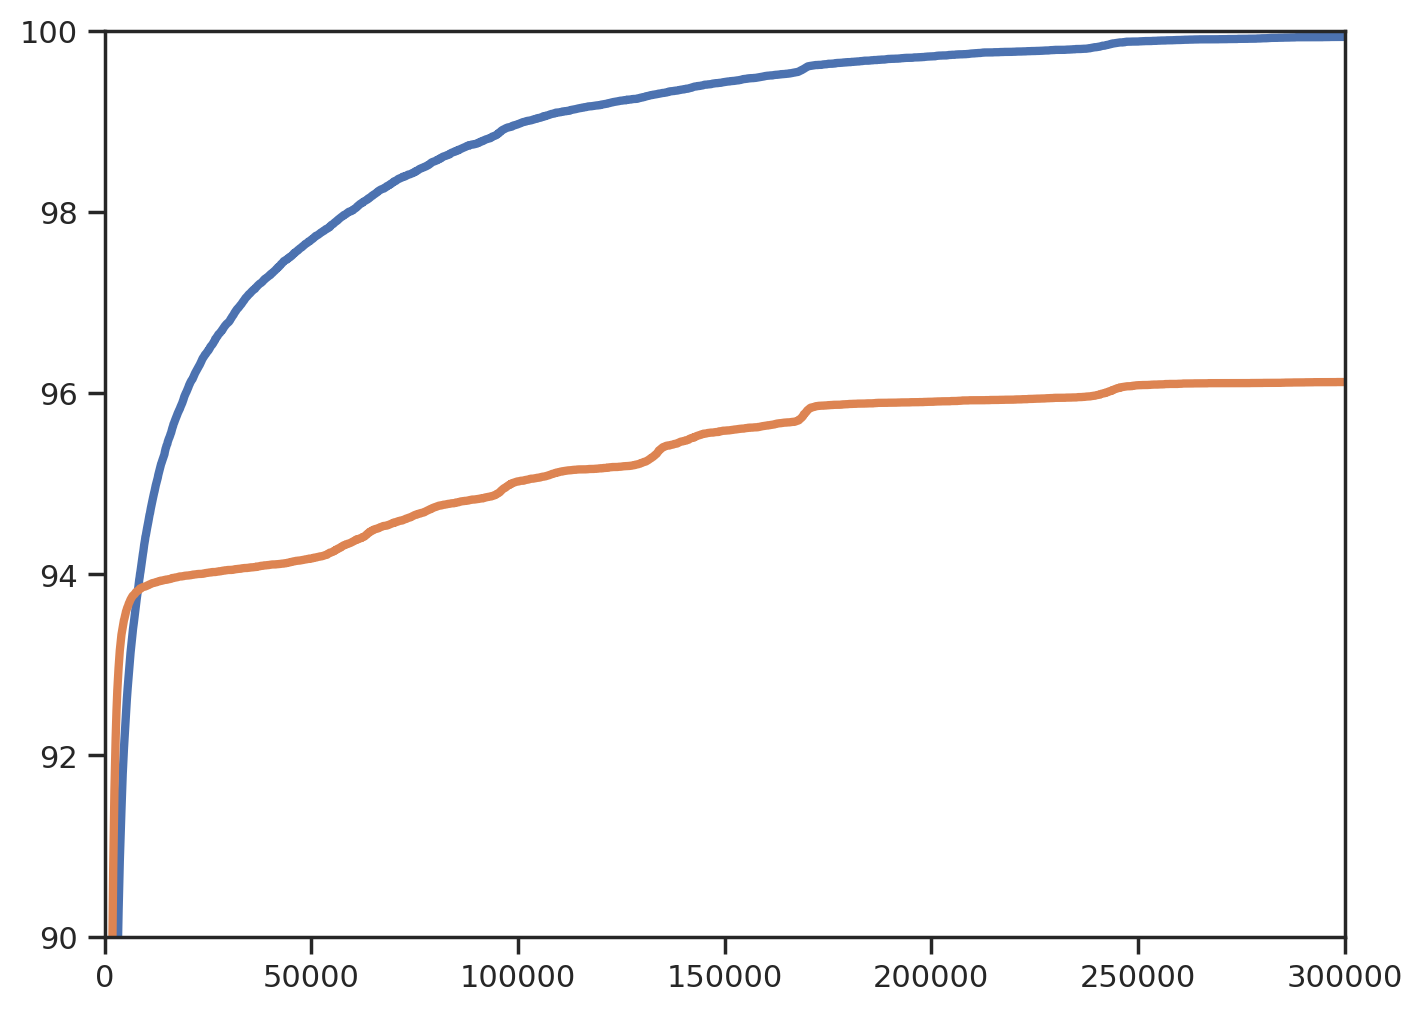

In [209]:
import seaborn as sns
sns.set_style("ticks")

vs = np.arange(0,3e5,100)
plt.plot(vs,accs_16, linewidth=3)
plt.plot(vs,accs_Q_16, linewidth=3)
plt.xlim(0,3e5)
plt.ylim(90,100)

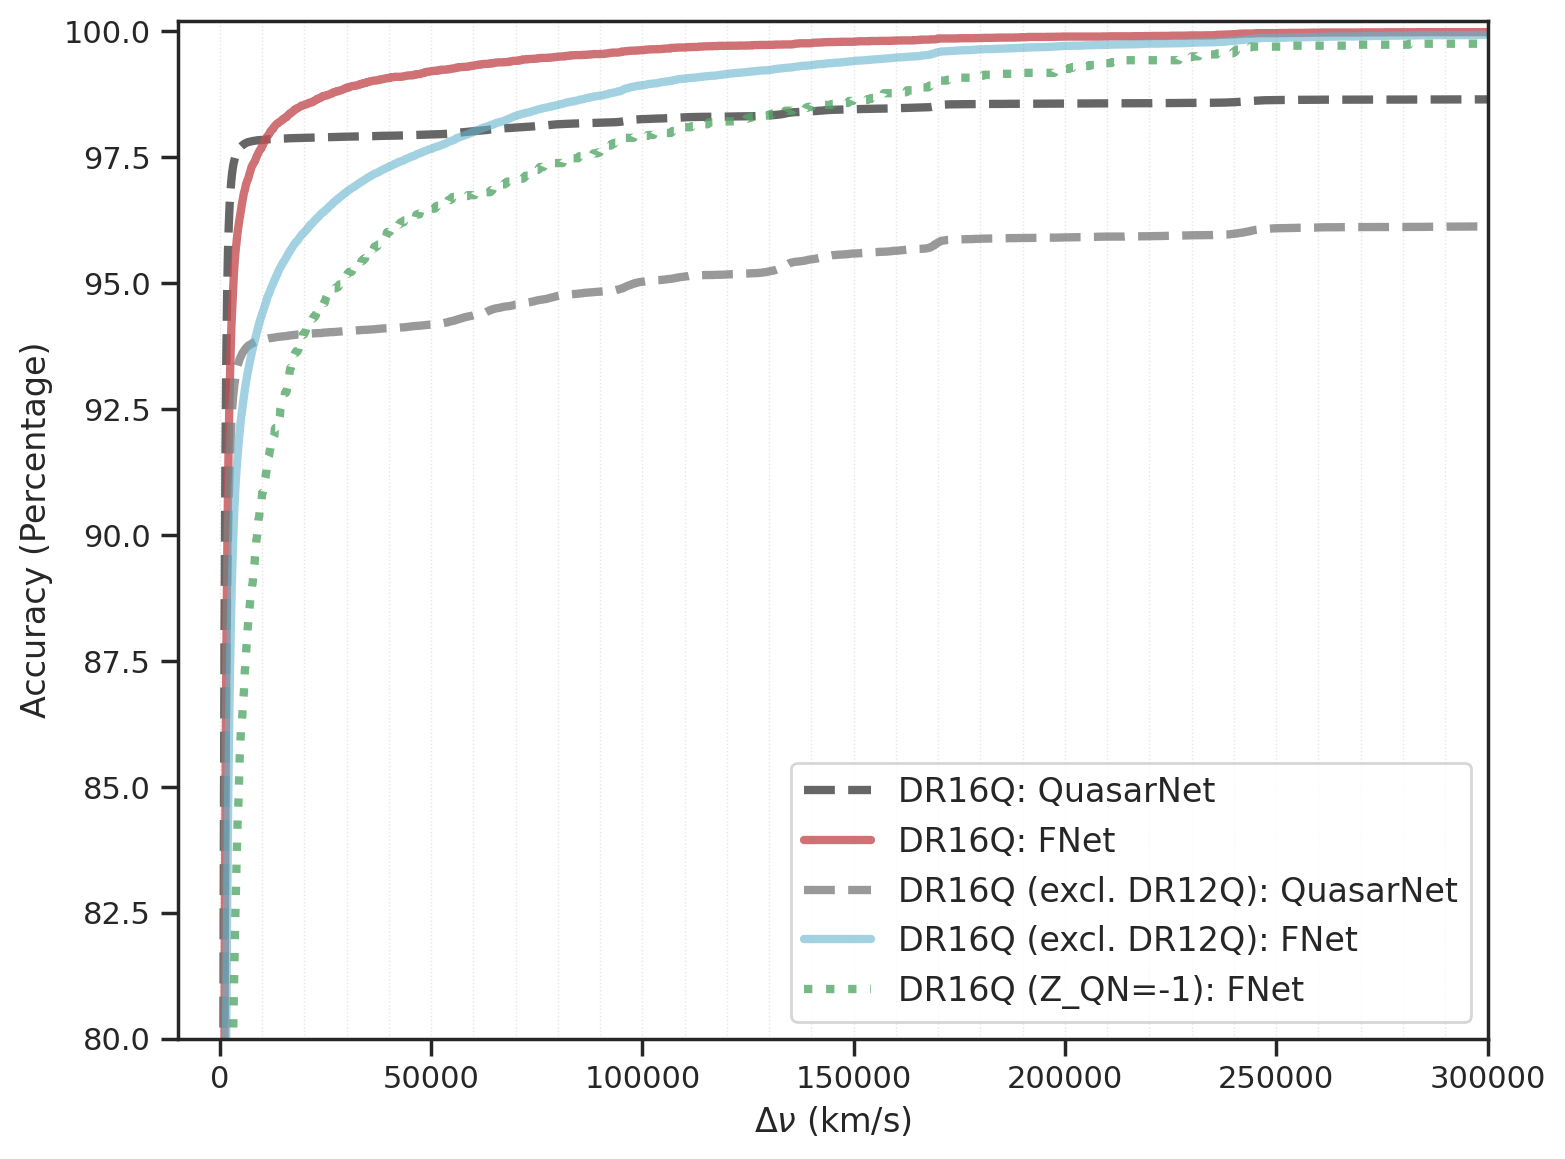

In [135]:
fig, ax = plt.subplots()

vs = np.arange(0,3e5,100)
plt.plot(vs,accs_e_Q, linewidth=3,linestyle ='dashed', alpha=0.6,color='black',label='DR16Q: QuasarNet')
plt.plot(vs,accs_e, linewidth=3,linestyle ='solid',alpha=0.8,color='C3',label='DR16Q: FNet')
plt.plot(vs,accs_Q_16, linewidth=3,linestyle ='dashed', alpha=0.8,color='grey',label='DR16Q (excl. DR12Q): QuasarNet')
plt.plot(vs,accs_16, linewidth=3,linestyle ='solid',alpha=0.6,color='C9',label='DR16Q (excl. DR12Q): FNet')
plt.plot(vs,accs_noZQN, linewidth=3,linestyle ='dotted',alpha=0.8,color='C2',label='DR16Q (Z_QN=-1): FNet')

#plt.hist(e_noZQN, bins=np.linspace(-5e5,5e5,5000),histtype='step',alpha=0.8,edgecolor='C3',linewidth=1.5,label='FNet')




plt.legend(title='',loc=4, prop={'size': 12})
plt.xlim(-10000,3e5)
plt.ylim(80,100.2)
#plt.xlim(-6000,6000)

for x in np.arange(0,3e5,10000):
    plt.axvline(x=x,linewidth=0.5,linestyle='dotted',color='grey',alpha=0.2)

#plt.ylim(1,1000)
plt.xlabel(r'$\Delta \nu$ (km/s)',fontsize=12)
plt.ylabel('Accuracy (Percentage)',fontsize=12)
plt.yscale('linear')

#from mpl_toolkits.axes_grid.inset_locator import inset_axes
#ax_in = inset_axes(ax,
#                    width="45%", # width = 30% of parent_bbox
#                    height=2., # height : 1 inch
#                    borderpad=2,
#                    loc=4)
#
#plt.plot(vs,accs_Q_16, linewidth=3,alpha=0.8,color='grey',label='QuasarNet')
#plt.plot(vs,accs_16, linewidth=3,alpha=0.8,color='C9',label='FNet')
#ax_in.hist(e_noZQN, bins=np.linspace(-5e5,5e5,5000),histtype='step',alpha=0.8,edgecolor='C3',linewidth=1.5,label='FNet')

#for x in np.arange(0,3e5,10000):
#    ax_in.axvline(x=x,linewidth=0.5,linestyle='--',color='grey',alpha=0.3)
#
#ax_in.set_xlim(100,3e5)
#ax_in.set_ylim(1,100)
#ax_in.set_xscale('log')
#ax_in.set_yscale('log')
#ax_in.tick_params(axis='both', which='major', labelsize=8)



fig.tight_layout()
plt.savefig('DR16QOnly_Accuracy.pdf', format='pdf')

In [306]:
Z_16_df = pd.DataFrame(data={'Z_VI_16': inv_norm(Z_VI_12, c_16), 'Z_16': inv_norm(Z_VI_12, b_16), 'dispersion': np.abs(e_16)})
Z_Q_16_df = pd.DataFrame(data={'Z_VI_16': Z_VI_16, 'Z_Q_16': Z_QN_16, 'dispersion': np.abs(e_Q_16)})
Z_Q_16_df = Z_Q_16_df[Z_Q_16_df['dispersion']<2.9e5]

In [317]:
Z_16_df_group = Z_16_df.groupby(pd.cut(Z_16_df["Z_VI_16"], np.arange(0, 7.0+0.1, 0.1))).mean()
Z_Q_16_df_group = Z_Q_16_df.groupby(pd.cut(Z_Q_16_df["Z_VI_16"], np.arange(0, 7.0+0.1, 0.1))).mean()

Text(0, 0.5, 'Median of Velocity Dispewrsion')

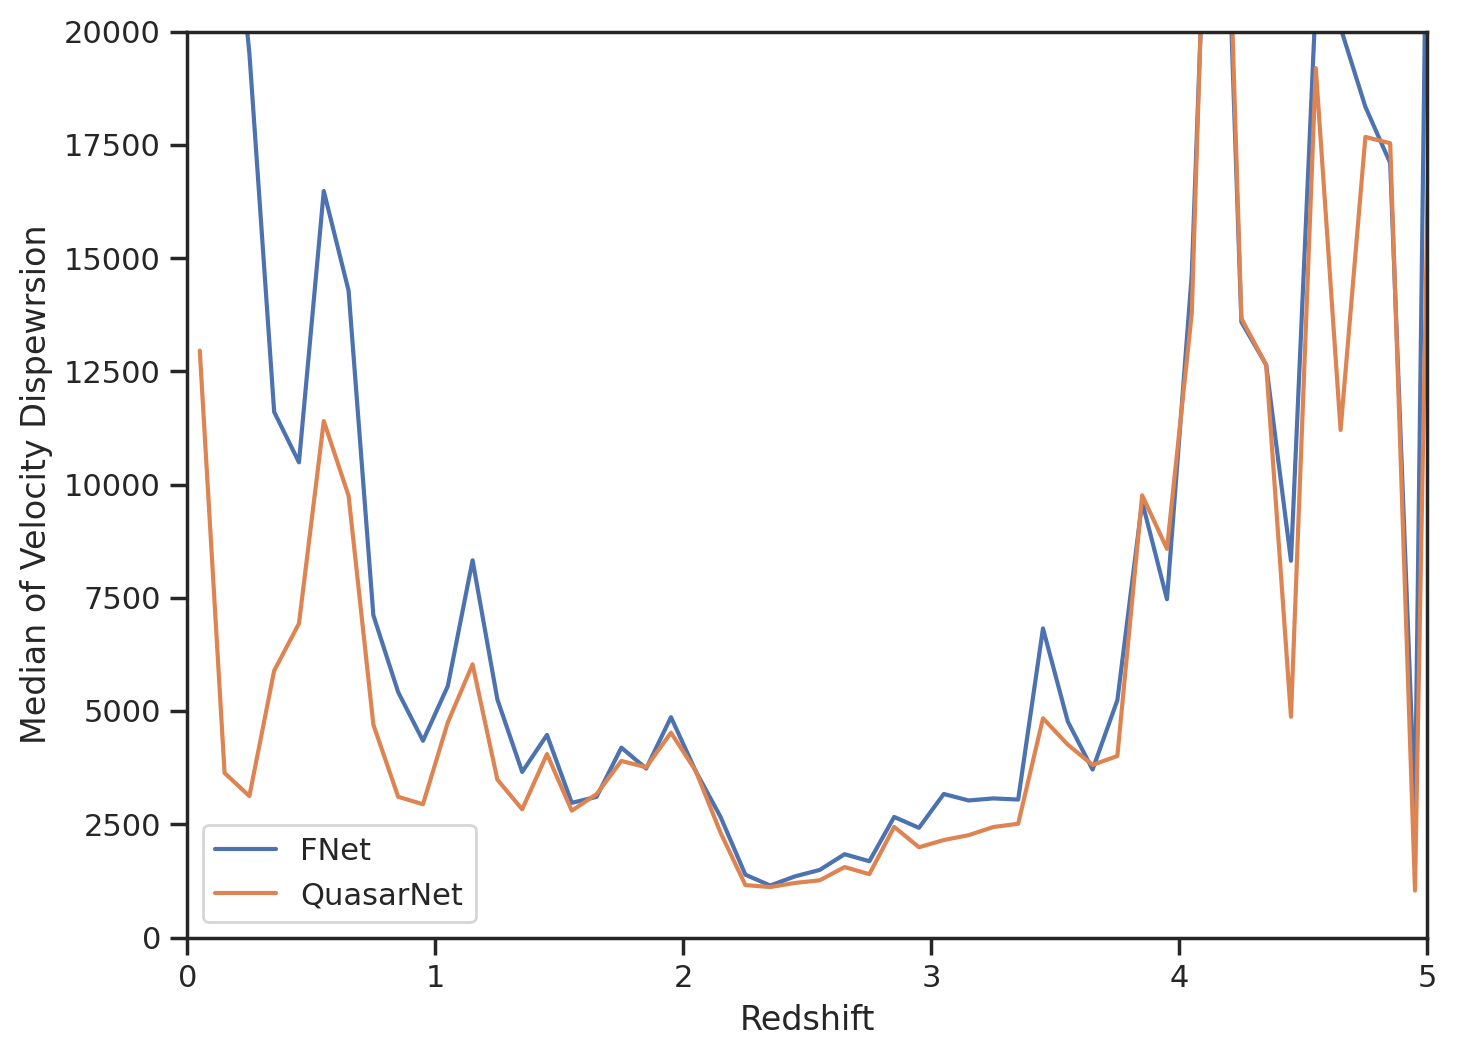

In [318]:
Zs = (np.arange(0, 7.0+0.1, 0.1)[1:] + np.arange(0, 7.0+0.1, 0.1)[:-1])/2

plt.plot(Zs,Z_16_df_group['dispersion'], label='FNet')
plt.plot(Zs,Z_Q_16_df_group['dispersion'], label='QuasarNet')
plt.xlim(0,5)
plt.ylim(0,20000)
plt.legend()
plt.xlabel('Redshift')
plt.ylabel('Median of Velocity Dispewrsion')

In [279]:
Z_Q_16_df_group

,Z_VI_16,Z_Q_16,dispersion
Z_VI_16,,,
"(0.0, 0.5]",1.9705,1.951248,-27.054698
"(0.5, 1.0]",1.9620,1.937943,-25.875485
"(1.0, 1.5]",1.9310,1.908525,-45.466800
"(1.5, 2.0]",1.9600,1.931831,-41.635194
"(2.0, 2.5]",1.9490,1.920224,-32.318005
"(2.5, 3.0]",1.9400,1.908733,-41.023344
"(3.0, 3.5]",1.9760,1.953175,-29.062922
"(3.5, 4.0]",1.9720,1.931888,-55.435164
"(4.0, 4.5]",1.9530,1.907741,-47.449282


In [251]:
np.array([inv_norm(Z_VI_12, c_16),inv_norm(Z_VI_12, b_16)])

array([[0.95400006, 1.8240001 , 3.055     , ..., 1.288     , 1.842     ,
        0.819     ],
       [0.78305423, 1.8271406 , 3.0436542 , ..., 1.2840979 , 1.8597411 ,
        0.82034504]], dtype=float32)

In [205]:
len(e_Q_16[np.abs(e_Q_16)>2.9e5])/len(e_Q_16)

0.038835999229138565

In [29]:
len(Z_QN_16[Z_QN_16==-1])/len(Z_QN_16)

0.03755636924262864

In [31]:
len(Z_QN_16[Z_QN_16==-1])

4872

In [32]:
len(Z_QN_16)

129725

In [248]:
inv_norm(Z_VI_12, b_16)

array([0.78305423, 1.8271406 , 3.0436542 , ..., 1.2840979 , 1.8597411 ,
       0.82034504], dtype=float32)

In [249]:
inv_norm(Z_VI_12, c_16)

array([0.95400006, 1.8240001 , 3.055     , ..., 1.288     , 1.842     ,
       0.819     ], dtype=float32)

In [235]:
d_PCA_VI_VI

array([[ 5860, 56046,   726],
       [10290, 58099,   598],
       [ 7855, 57011,   224],
       ...,
       [10753, 58242,   105],
       [ 5699, 55953,   208],
       [ 7604, 56947,   100]], dtype=int32)

In [236]:
d_PCA_VI_PCA

array([[ 6027, 56103,   652],
       [ 7692, 57064,   184],
       [ 4363, 55537,   962],
       ...,
       [ 6442, 56369,    46],
       [ 8358, 57451,   522],
       [ 4508, 55600,   252]], dtype=int32)

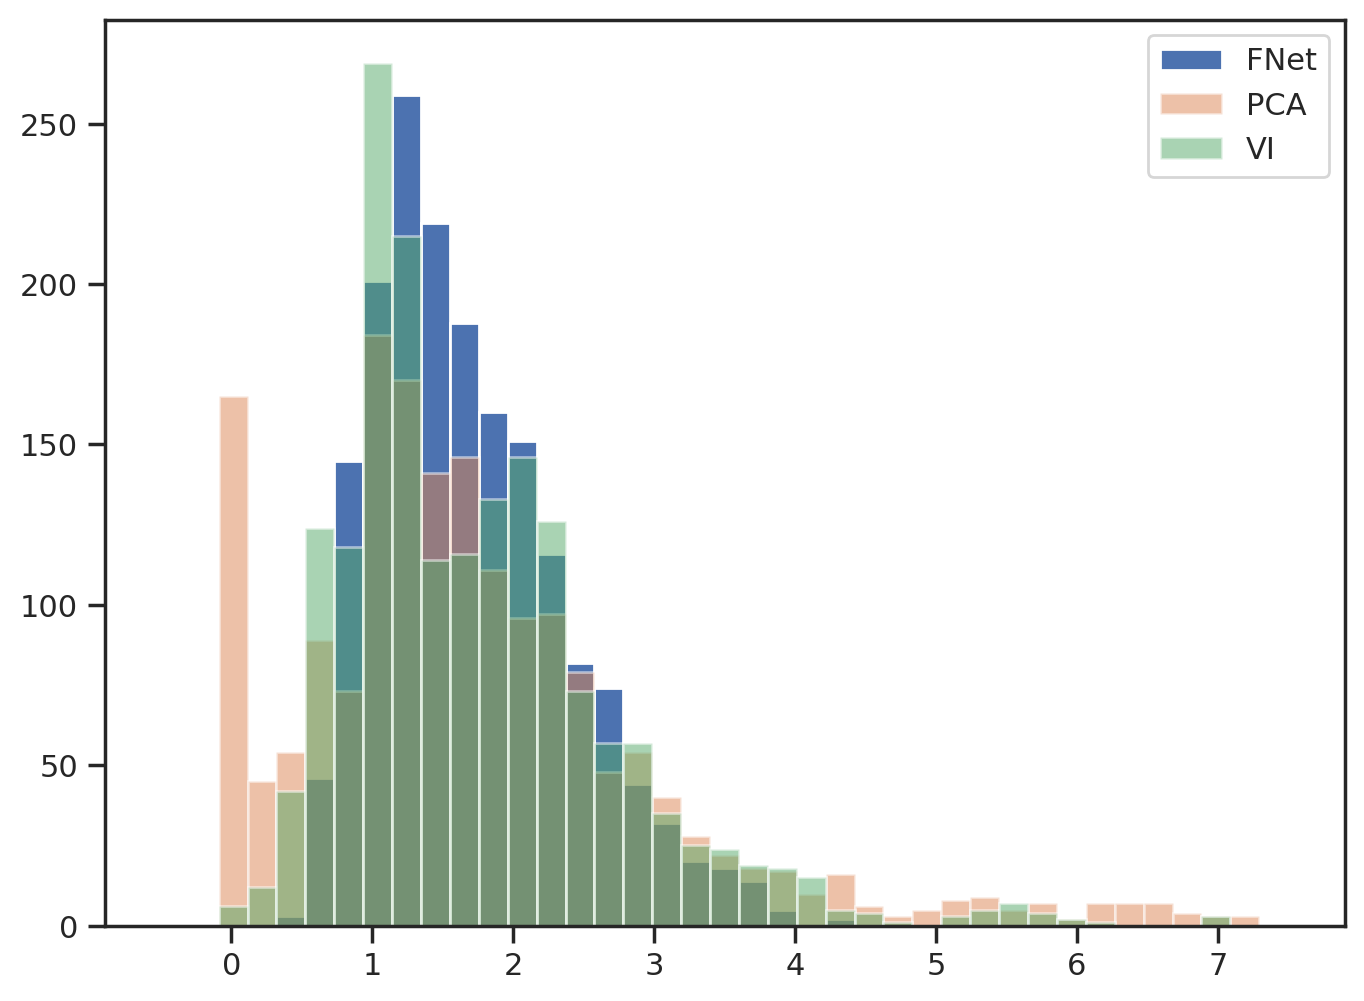

In [250]:
plt.hist(inv_norm(Z_VI_12, b_PCA_VI_VI),bins=np.linspace(-0.5,7.5,40),label='FNet')
plt.hist(inv_norm(Z_VI_12, c_PCA_VI_PCA),bins=np.linspace(-0.5,7.5,40),alpha=0.5,label='PCA')
plt.hist(inv_norm(Z_VI_12, c_PCA_VI_VI),bins=np.linspace(-0.5,7.5,40),alpha=0.5,label='VI')
plt.legend()

Text(0, 0.5, 'Number')

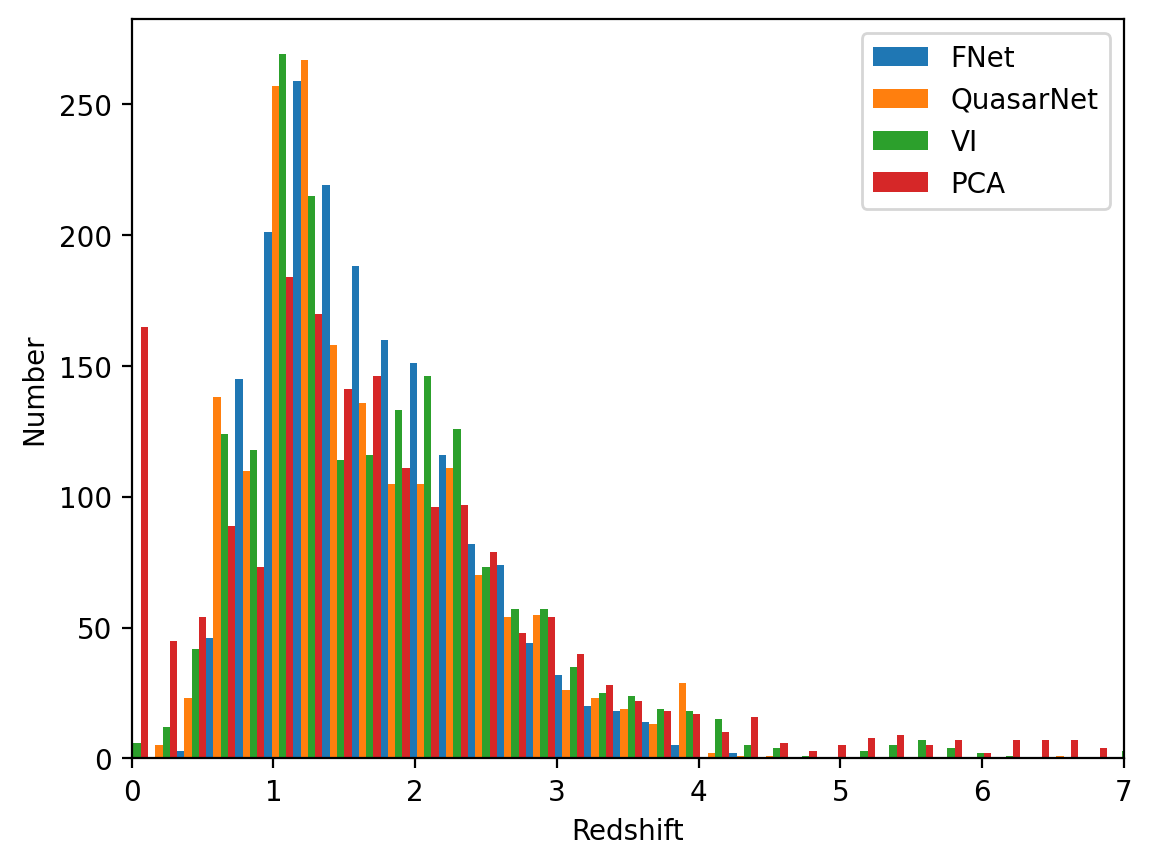

In [309]:
plt.style.use('default')
plt.hist([inv_norm(Z_VI_12, b_PCA_VI_VI), Z_QN_PCA_VI, Z_VI_PCA_VI, Z_PCA_PCA_VI],\
         bins=np.linspace(-0.5,7.5,40), histtype='bar', rwidth=2, label=['FNet', 'QuasarNet', 'VI', 'PCA'])
plt.legend()
plt.xlim(0,7)
plt.xlabel('Redshift')
plt.ylabel('Number')

Statistically speaking, the redshifts obtained by PCA are the closest to those detected by visual inspection, its median velocity difference is ..., except that PCA obtains some extreme redshifts, of which close to 0 or larger than 6, are neither listed in the redshfits obtained from visual inspection nor from FNet and QuasarNet.

(array([[2.2450e+03, 8.0900e+03, 6.6260e+03, 1.6814e+04, 4.8160e+03,
         9.5900e+02, 1.2400e+02, 1.0000e+01, 0.0000e+00, 0.0000e+00],
        [2.3220e+03, 8.0620e+03, 6.5240e+03, 1.6834e+04, 4.8320e+03,
         9.7000e+02, 1.2400e+02, 1.5000e+01, 0.0000e+00, 1.0000e+00]]),
 array([-2.2450909e-03,  6.9287938e-01,  1.3880038e+00,  2.0831282e+00,
         2.7782526e+00,  3.4733772e+00,  4.1685014e+00,  4.8636260e+00,
         5.5587506e+00,  6.2538748e+00,  6.9489994e+00], dtype=float32),
 <a list of 2 BarContainer objects>)

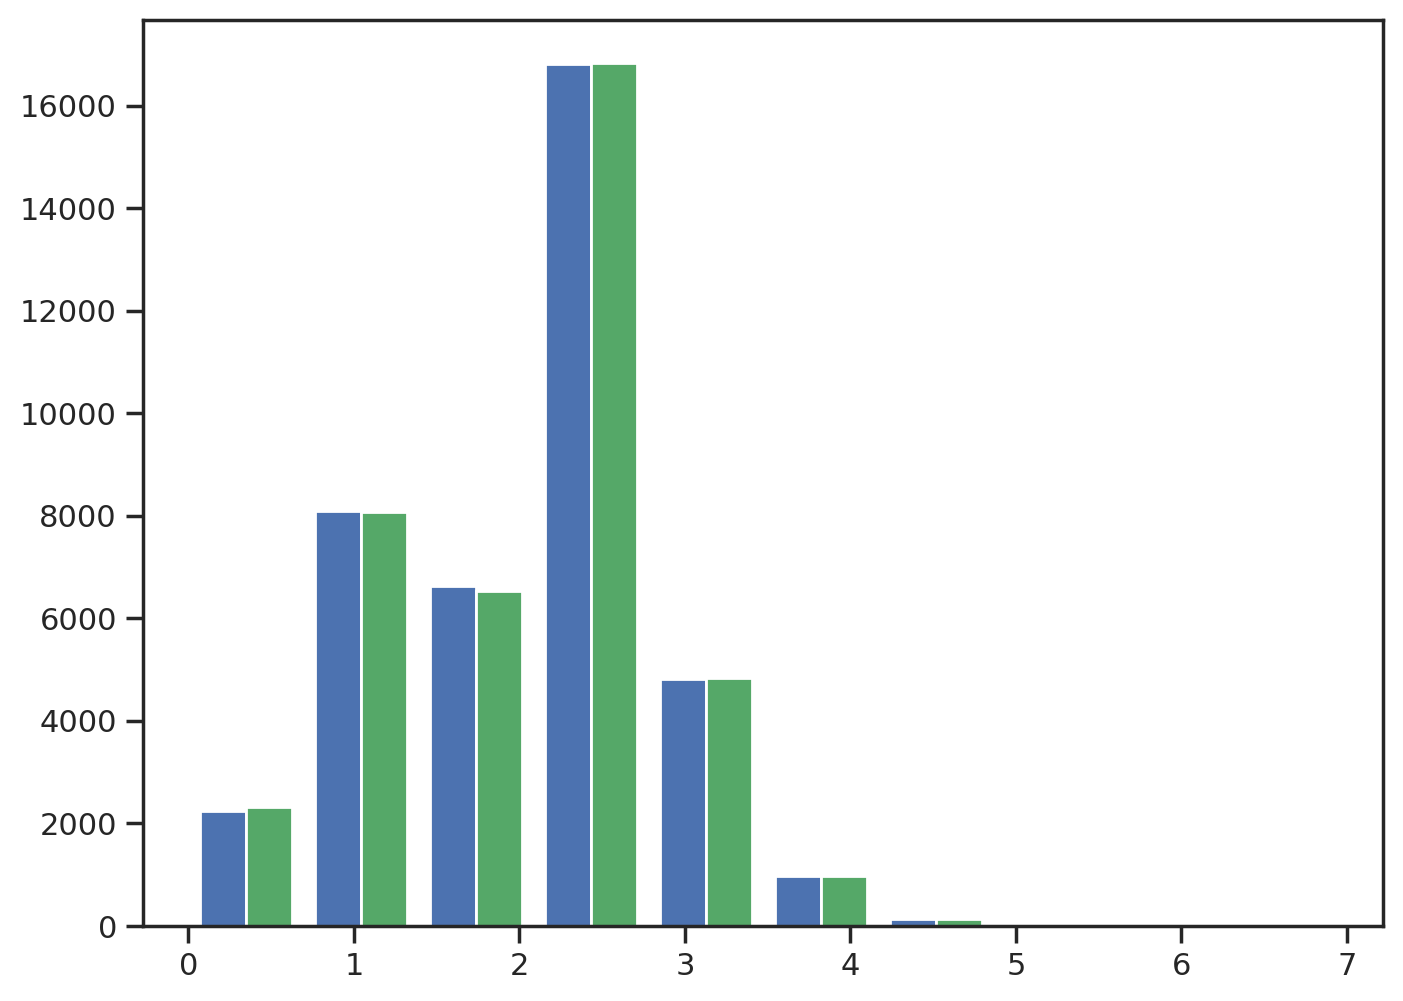

In [281]:
plt.hist([inv_norm(Z_VI_12, b),inv_norm(Z_VI_12, c)])

In [271]:
Zs[Zs>5]

array([5.0252323, 5.164962 , 5.440971 , 5.000955 , 5.0782924, 5.0933704,
       5.037739 , 5.027091 ], dtype=float32)

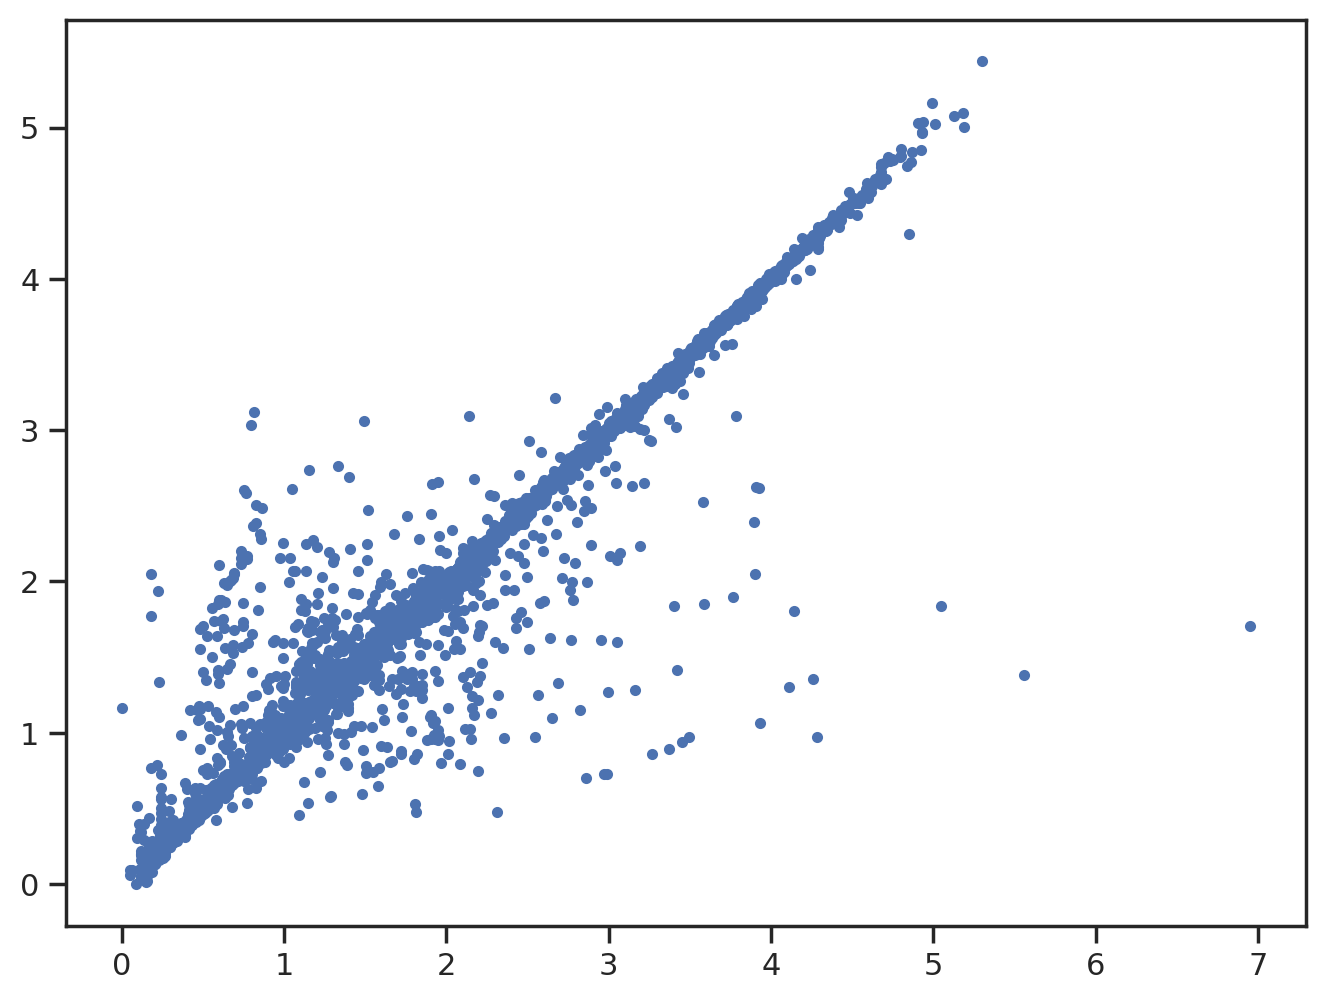

In [277]:
plt.plot(inv_norm(Z_VI_12, c),inv_norm(Z_VI_12, b),'.')

In [280]:
Z_QN[Z_QN>5.5]

array([6.508474 , 6.5017776], dtype=float32)